In [1]:
!pwd
cp -r /Users/sts/Desktop/jptglv/NYC-vehicle-crash/.itignore .


/Users/sts/Desktop/project2/NYC-Citi-bike-


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below,
# this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
df = pd.read_csv('data/mar2019-feb2020_top1.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1, inplace = True )

df.shape # (1048575, 15)
# df.head()
df.tail(1)

(104211, 26)

Day  bikeid  birth year       dates  day of year  end station id  \
104210   18   18317        1955  2019-04-18          108           540.0   

        end station latitude  end station longitude         end station name  \
104210             40.743116             -73.982154  Lexington Ave & E 29 St   

        gender  ...     starttime      stoptime  tripduration    usertype  \
104210       1  ...  4/18/19 9:19  4/18/19 9:27           433  Subscriber   

        week weekday start time stop time  Trip in Minutes age  
104210    16       3       9:19      9:27              7.0  64  

[1 rows x 26 columns]

In [5]:
df.shape
df.head()

(104211, 26)

Day  bikeid  birth year       dates  day of year  end station id  \
0    1   35644        1979  2019-03-01           60           492.0   
1    1   19229        1989  2019-03-01           60           164.0   
2    1   19305        1995  2019-03-01           60           479.0   
3    1   34790        1989  2019-03-01           60          3258.0   
4    1   35552        1969  2019-03-01           60          3437.0   

   end station latitude  end station longitude        end station name  \
0             40.750200             -73.990931         W 33 St & 7 Ave   
1             40.753231             -73.970325         E 47 St & 2 Ave   
2             40.760193             -73.991255         9 Ave & W 45 St   
3             40.750182             -74.002184        W 27 St & 10 Ave   
4             40.793135             -73.977004  Riverside Dr & W 91 St   

   gender  ...    starttime     stoptime  tripduration    usertype  week  \
0       1  ...  3/1/19 0:13  3/1/19 0:20           415  Subscriber     9   
1       1  ...  3/1/19 0:22  3/1/19 0:26           260  Subscriber     9   
2       1  ...  3/1/19 0:31  3/1/19 0:38           395  Subscriber     9   
3       2  ...  3/1/19 4:16  3/1/19 4:25           540  Subscriber     9   
4       1  ...  3/1/19 4:24  3/1/19 4:48          1456  Subscriber     9   

  weekday start time stop time  Trip in Minutes age  
0       4       0:13      0:20              7.0  40  
1       4       0:22      0:26              4.0  30  
2       4       0:31      0:38              7.0  24  
3       4       4:16      4:25              9.0  30  
4       4       4:24      4:48             24.0  50  

[5 rows x 26 columns]

In [6]:
df.describe()

Day         bikeid     birth year    day of year  \
count  104211.000000  104211.000000  104211.000000  104211.000000   
mean       11.500091   29855.523735    1977.548378     174.812218   
std         7.262213    7535.163314      12.021379     101.643785   
min         1.000000   14529.000000    1886.000000       1.000000   
25%         6.000000   25665.000000    1969.000000      85.000000   
50%        11.000000   30820.000000    1978.000000     186.000000   
75%        16.000000   35065.000000    1988.000000     254.000000   
max        31.000000   42631.000000    2003.000000     365.000000   

       end station id  end station latitude  end station longitude  \
count   104211.000000         104211.000000          104211.000000   
mean      1151.976049             40.745567             -73.986258   
std       1274.777776              0.016070               0.012280   
min         72.000000             40.661063             -74.017134   
25%        442.000000             40.739017             -73.993012   
50%        492.000000             40.745712             -73.987654   
75%        546.000000             40.754666             -73.979955   
max       3918.000000             40.818299             -73.907744   

              gender           hour  start station id  start station latitude  \
count  104211.000000  104211.000000          104211.0            1.042110e+05   
mean        1.079022      13.520089             519.0            4.075187e+01   
std         0.404919       4.858000               0.0            3.934114e-07   
min         0.000000       0.000000             519.0            4.075187e+01   
25%         1.000000       9.000000             519.0            4.075187e+01   
50%         1.000000      15.000000             519.0            4.075187e+01   
75%         1.000000      18.000000             519.0            4.075187e+01   
max         2.000000      23.000000             519.0            4.075200e+01   

       start station longitude  tripduration           week        weekday  \
count            104211.000000  1.042110e+05  104211.000000  104211.000000   
mean                -73.977706  8.611227e+02      25.511491       2.431615   
std                   0.000002  9.863335e+03      14.466095       1.723886   
min                 -73.977706  6.100000e+01       1.000000       0.000000   
25%                 -73.977706  4.410000e+02      13.000000       1.000000   
50%                 -73.977706  6.230000e+02      27.000000       2.000000   
75%                 -73.977706  9.710000e+02      37.000000       4.000000   
max                 -73.977000  2.946638e+06      52.000000       6.000000   

       Trip in Minutes            age  
count    104211.000000  104211.000000  
mean         14.350779      41.451622  
std         164.390458      12.021379  
min           1.000000      16.000000  
25%           7.000000      31.000000  
50%          10.000000      41.000000  
75%          16.000000      50.000000  
max       49111.000000     133.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104211 entries, 0 to 104210
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Day                      104211 non-null  int64  
 1   bikeid                   104211 non-null  int64  
 2   birth year               104211 non-null  int64  
 3   dates                    104211 non-null  object 
 4   day of year              104211 non-null  int64  
 5   end station id           104211 non-null  float64
 6   end station latitude     104211 non-null  float64
 7   end station longitude    104211 non-null  float64
 8   end station name         104211 non-null  object 
 9   gender                   104211 non-null  int64  
 10  hour                     104211 non-null  int64  
 11  month                    104211 non-null  object 
 12  start station id         104211 non-null  float64
 13  start station latitude   104211 non-null  float64
 14  star

In [8]:
df.dtypes

Day                          int64
bikeid                       int64
birth year                   int64
dates                       object
day of year                  int64
end station id             float64
end station latitude       float64
end station longitude      float64
end station name            object
gender                       int64
hour                         int64
month                       object
start station id           float64
start station latitude     float64
start station longitude    float64
start station name          object
starttime                   object
stoptime                    object
tripduration                 int64
usertype                    object
week                         int64
weekday                      int64
start time                  object
stop time                   object
Trip in Minutes            float64
age                          int64
dtype: object

In [9]:
df.groupby('dates').count()

Day  bikeid  birth year  day of year  end station id  \
dates                                                              
2019-03-01  345     345         345          345             345   
2019-03-02   59      59          59           59              59   
2019-03-03   51      51          51           51              51   
2019-03-04  295     295         295          295             295   
2019-03-05  347     347         347          347             347   
...         ...     ...         ...          ...             ...   
2020-02-23  146     146         146          146             146   
2020-02-24  612     612         612          612             612   
2020-02-25  372     372         372          372             372   
2020-02-26  453     453         453          453             453   
2020-02-27  202     202         202          202             202   

            end station latitude  end station longitude  end station name  \
dates                                                                       
2019-03-01                   345                    345               345   
2019-03-02                    59                     59                59   
2019-03-03                    51                     51                51   
2019-03-04                   295                    295               295   
2019-03-05                   347                    347               347   
...                          ...                    ...               ...   
2020-02-23                   146                    146               146   
2020-02-24                   612                    612               612   
2020-02-25                   372                    372               372   
2020-02-26                   453                    453               453   
2020-02-27                   202                    202               202   

            gender  hour  ...  starttime  stoptime  tripduration  usertype  \
dates                     ...                                                
2019-03-01     345   345  ...        345       345           345       345   
2019-03-02      59    59  ...         59        59            59        59   
2019-03-03      51    51  ...         51        51            51        51   
2019-03-04     295   295  ...        295       295           295       295   
2019-03-05     347   347  ...        347       347           347       347   
...            ...   ...  ...        ...       ...           ...       ...   
2020-02-23     146   146  ...        146       146           146       146   
2020-02-24     612   612  ...        612       612           612       612   
2020-02-25     372   372  ...        372       372           372       372   
2020-02-26     453   453  ...        453       453           453       453   
2020-02-27     202   202  ...        202       202           202       202   

            week  weekday  start time  stop time  Trip in Minutes  age  
dates                                                                   
2019-03-01   345      345         345        345              345  345  
2019-03-02    59       59          59         59               59   59  
2019-03-03    51       51          51         51               51   51  
2019-03-04   295      295         295        295              295  295  
2019-03-05   347      347         347        347              347  347  
...          ...      ...         ...        ...              ...  ...  
2020-02-23   146      146         146        146              146  146  
2020-02-24   612      612         612        612              612  612  
2020-02-25   372      372         372        372              372  372  
2020-02-26   453      453         453        453              453  453  
2020-02-27   202      202         202        202              202  202  

[256 rows x 25 columns]

In [10]:
# total number of bike stations started from stationID 519 : 764

df['end station id'].count()
# df['end station id'].unique()#.sort_values(ascending = False) #
df['end station id'].nunique() # 764


104211

764

In [11]:
# total number of bikes 15235

df['bikeid'].count() # 1048575
df['bikeid'].unique().max()#.sort_values(ascending = False) #
df['bikeid'].nunique() # 15235


104211

42631

18795

In [12]:
# date time to data_time format 

timestamp = pd.to_datetime(df['starttime'])

df['dates'] = timestamp.dt.date
df['hour'] = timestamp.dt.hour
df['Day'] = timestamp.dt.day  # 1-30
df['week'] = timestamp.dt.week # numbers of week 1 - 14 
df['month'] = timestamp.dt.strftime('%Y-%m')
# df['dayofweek'] = timestamp.dt.dayofweek # 0, 6 days 
df['weekday'] = timestamp.dt.weekday  # 0-6 days 
df['day of year'] = timestamp.dt.dayofyear # day by year 1-90

In [13]:
# create day of month column 
# df['day of month'] = df['starttime'].apply(lambda x: x.split()[0])

# create hh:mm column time 
df['start time'] = df['starttime'].apply(lambda x: x.split()[1])
df['stop time'] = df['stoptime'].apply(lambda x: x.split()[1])

In [14]:
# Create different new columns for hour, each month and year-month from given Date and time columns 

hours = df['start time'].str.split(":", expand = True)

df['hour'] = hours[0]

# make 01 02, ... in hour to sort 
df['hour'] = df['hour'].apply(lambda x: x.zfill(2))

# days = df['day of month'].str.split("/", expand = True)
# df['day'] = days[1]
# df['day'] = df['day'].apply(lambda x: x.zfill(2))

# days = df['day of month'].str.split("/", expand = True)
# df['day'] = days[1]
# df['day'] = df['day'].apply(lambda x: x.zfill(2))


In [15]:
# group by day of the month 
# daily_count = df.groupby(['day of month','start station name']).count()['start station id'].sort_values(ascending = False)
daily_count = df.groupby('dates').count()['start station id'].sort_values(ascending = False)

daily_count.head(4)


dates
2019-09-09    864
2019-09-10    825
2019-10-10    815
2019-09-05    805
Name: start station id, dtype: int64

In [16]:
df.tail(2)

Day  bikeid  birth year       dates  day of year  end station id  \
104209   18   32196        1958  2019-04-18          108           168.0   
104210   18   18317        1955  2019-04-18          108           540.0   

        end station latitude  end station longitude         end station name  \
104209             40.739713             -73.994564          W 18 St & 6 Ave   
104210             40.743116             -73.982154  Lexington Ave & E 29 St   

        gender  ...     starttime      stoptime  tripduration    usertype  \
104209       1  ...  4/18/19 9:20  4/18/19 9:30           640  Subscriber   
104210       1  ...  4/18/19 9:19  4/18/19 9:27           433  Subscriber   

        week weekday start time stop time  Trip in Minutes age  
104209    16       3       9:20      9:30             11.0  61  
104210    16       3       9:19      9:27              7.0  64  

[2 rows x 26 columns]

In [17]:
# Top end/stop stations
stop_stations = df.groupby('end station name').count()['start station id'].sort_values(ascending = False)
stop_stations.head()

end station name
E 24 St & Park Ave S    3326
W 33 St & 7 Ave         3171
W 41 St & 8 Ave         2078
E 30 St & Park Ave S    1920
Broadway & E 22 St      1845
Name: start station id, dtype: int64

In [18]:
# trip duration time in minute; seconds given 
df['Trip in Minutes'] = df['tripduration'].apply(lambda x: x/60.0).round(0)
# df

In [19]:
df['age'] = df['birth year'].apply(lambda x: 2019 - x)


In [20]:
# user type: Subscriber & Customer[non-subscriber] 16.87 ratio
# percentage: 14.43 % non-subscriber  

df.usertype.unique() # array(['Subscriber', 'Customer'], dtype=object)
subs = df[df.usertype == 'Subscriber'].count() # 897222
cust = df[df.usertype == 'Customer'].count() # 151353
user_perc = cust/(subs+cust)
# user_perc


array(['Subscriber', 'Customer'], dtype=object)

Text(0.5, 1.0, 'Daily bike rides Mar2019-Feb2020')

Text(0.5, 0, 'Day of year (Day 1: March 1,2019 )')

Text(0, 0.5, 'Number of bike rides')

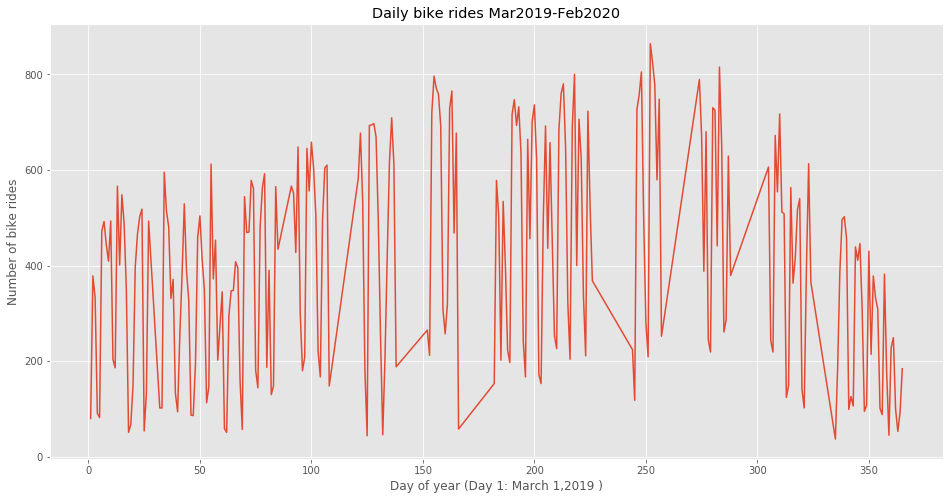

In [21]:
y = df.groupby('day of year')['day of year'].count()
y.plot(figsize = (16,8))
plt.title("Daily bike rides Mar2019-Feb2020")
plt.xlabel('Day of year (Day 1: March 1,2019 )')
plt.ylabel("Number of bike rides")
plt.savefig('Bike daily rides (Raw Data)')
plt.show()

In [22]:
df.head()

Day  bikeid  birth year       dates  day of year  end station id  \
0    1   35644        1979  2019-03-01           60           492.0   
1    1   19229        1989  2019-03-01           60           164.0   
2    1   19305        1995  2019-03-01           60           479.0   
3    1   34790        1989  2019-03-01           60          3258.0   
4    1   35552        1969  2019-03-01           60          3437.0   

   end station latitude  end station longitude        end station name  \
0             40.750200             -73.990931         W 33 St & 7 Ave   
1             40.753231             -73.970325         E 47 St & 2 Ave   
2             40.760193             -73.991255         9 Ave & W 45 St   
3             40.750182             -74.002184        W 27 St & 10 Ave   
4             40.793135             -73.977004  Riverside Dr & W 91 St   

   gender  ...    starttime     stoptime  tripduration    usertype  week  \
0       1  ...  3/1/19 0:13  3/1/19 0:20           415  Subscriber     9   
1       1  ...  3/1/19 0:22  3/1/19 0:26           260  Subscriber     9   
2       1  ...  3/1/19 0:31  3/1/19 0:38           395  Subscriber     9   
3       2  ...  3/1/19 4:16  3/1/19 4:25           540  Subscriber     9   
4       1  ...  3/1/19 4:24  3/1/19 4:48          1456  Subscriber     9   

  weekday start time stop time  Trip in Minutes age  
0       4       0:13      0:20              7.0  40  
1       4       0:22      0:26              4.0  30  
2       4       0:31      0:38              7.0  24  
3       4       4:16      4:25              9.0  30  
4       4       4:24      4:48             24.0  50  

[5 rows x 26 columns]

Text(0.5, 1.0, 'Hourly bike rides of each day ')

Text(0.5, 0, 'Hour of the day ')

Text(0, 0.5, 'Number of bike rides')

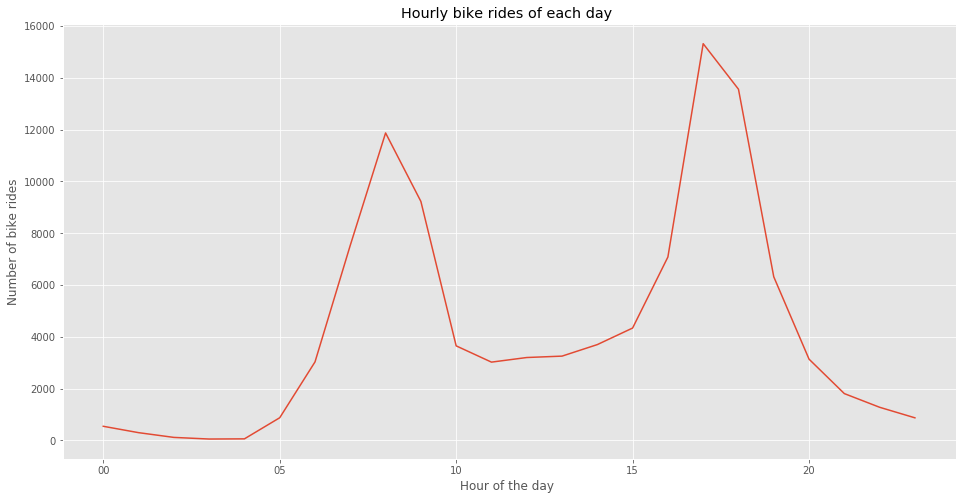

In [23]:
# hourly bike rides 
y = df.groupby('hour')['hour'].count()
y.plot(figsize = (16,8))
plt.title("Hourly bike rides of each day ")
plt.xlabel('Hour of the day ')
plt.ylabel("Number of bike rides")
plt.savefig('Hourly_rides')
plt.show()

Text(0.5, 1.0, 'Hourly bike rides of each day ')

Text(0.5, 0, 'Hour of the day ')

Text(0, 0.5, 'Number of bike rides')

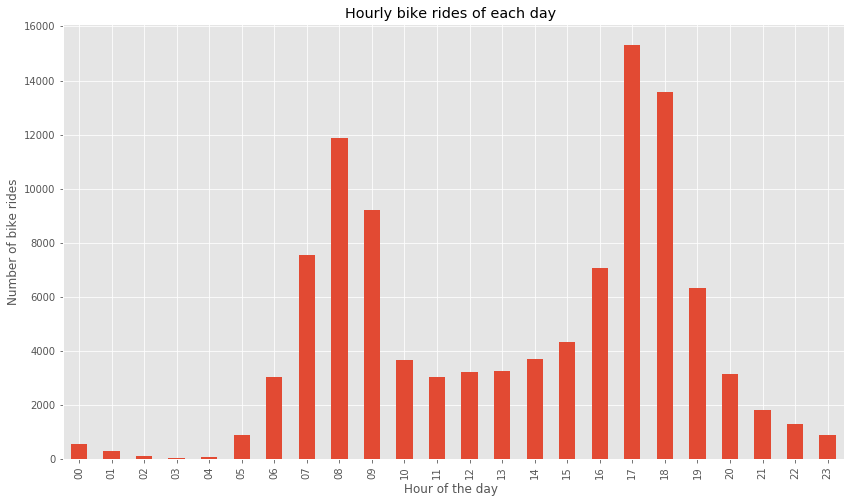

In [24]:
# hourly bike rides histogram
hourly = df.groupby('hour')['hour'].count()
# hourly.plot(figsize = (14,8), color = 'b')
# plt.hist(df['hour'], bins = 24)
hourly.plot(kind = 'bar', figsize = (14,8))

plt.title("Hourly bike rides of each day ")
plt.xlabel('Hour of the day ')
plt.ylabel("Number of bike rides")
plt.savefig('Hourly_rides')
plt.show()

Text(0.5, 1.0, 'Weekly Riding trend of each day  on week')

Text(0.5, 0, 'Day of the week')

([<matplotlib.axis.XTick at 0x1a2a7e7d50>,
 <a list of 7 Text xticklabel objects>)

Text(0, 0.5, 'Number of bike rides')

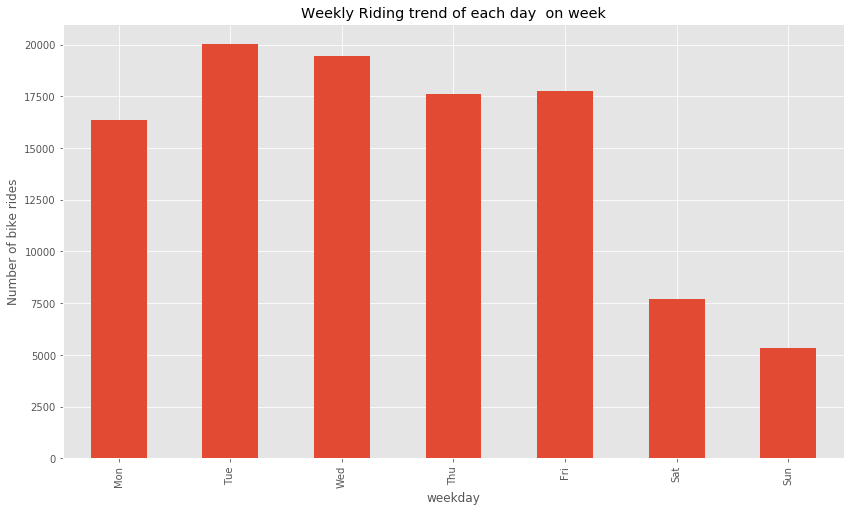

In [25]:
day_of_week = df.groupby('weekday')['weekday'].count()
# day_of_week.plot(figsize = (16,8), color = 'b')
plt.title("Weekly Riding trend of each day  on week")
plt.xlabel('Day of the week')
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_of_week.plot(kind = 'bar', figsize = (14,8))
plt.xticks(range(len(days)), days)
plt.ylabel("Number of bike rides")
plt.savefig('Weekly riding trend')
plt.show()

Text(0.5, 1.0, 'Days of year bike rides Mar2019-Feb2020 [Raw Data]')

Text(0.5, 0, 'Day of the month of the year ')

Text(0, 0.5, 'Number of bike rides')

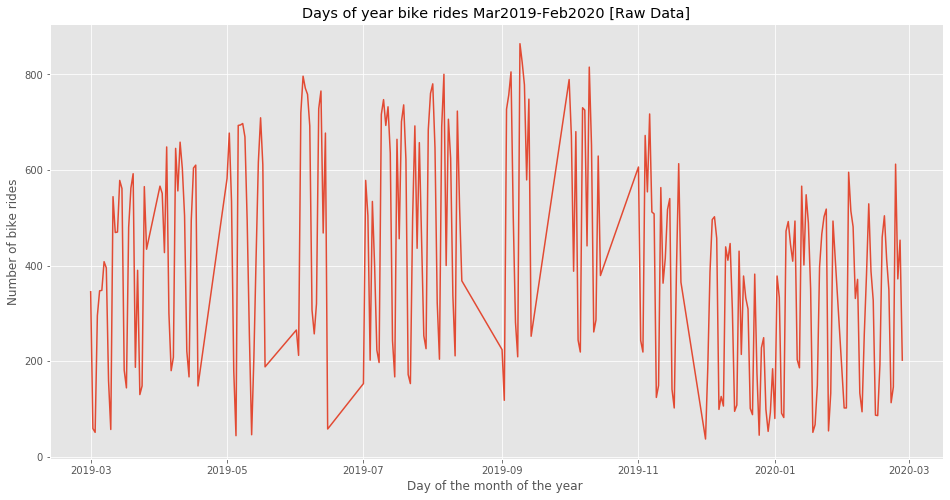

In [85]:
y = df.groupby('dates')['dates'].count()
y.plot(figsize = (16,8))
plt.title("Days of year bike rides Mar2019-Feb2020 [Raw Data]")
plt.xlabel('Day of the month of the year ')
plt.ylabel("Number of bike rides")
plt.savefig('Daily rides [Raw Data]')
plt.show()

In [27]:
df.groupby('dates')['dates'].count()


dates
2019-03-01    345
2019-03-02     59
2019-03-03     51
2019-03-04    295
2019-03-05    347
             ... 
2020-02-23    146
2020-02-24    612
2020-02-25    372
2020-02-26    453
2020-02-27    202
Name: dates, Length: 256, dtype: int64

Text(0.5, 1.0, 'Weekly bike rides  Mar2019-Feb2020')

Text(0.5, 0, 'week of the year (week 1: March 1,2019 )')

Text(0, 0.5, 'Number of bike rides')

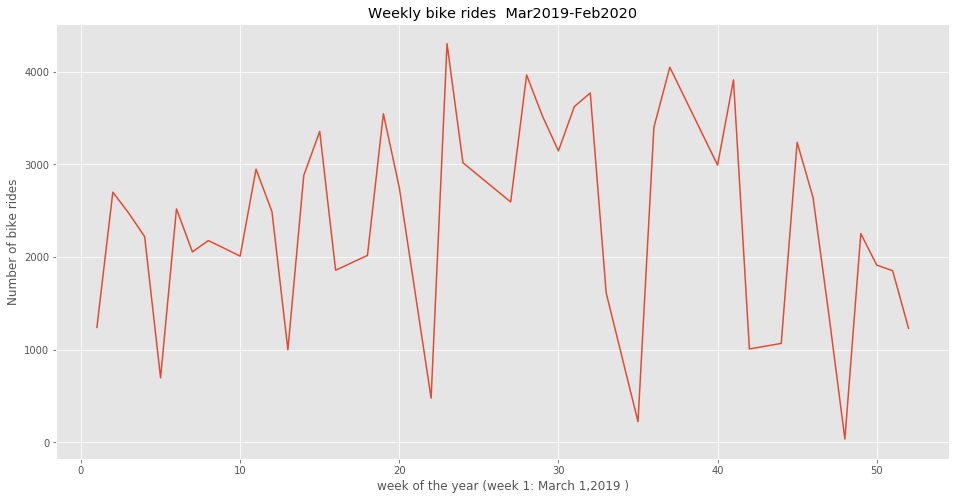

In [28]:
week_count = df.groupby('week')['week'].count()
week_count.plot(figsize = (16,8))
plt.title("Weekly bike rides  Mar2019-Feb2020")
plt.xlabel('week of the year (week 1: March 1,2019 )')
plt.ylabel("Number of bike rides")
plt.savefig('Weekly rides')
plt.show()

In [29]:
monthly = df.groupby('month')['month'].count()


In [30]:
y = df.groupby('day of year')['day of year'].count()
y.iloc[50:]

day of year
55     612
56     372
57     453
58     202
60     345
      ... 
361    249
362     99
363     53
364     93
365    184
Name: day of year, Length: 206, dtype: int64

In [31]:
df.columns

Index(['Day', 'bikeid', 'birth year', 'dates', 'day of year', 'end station id',
       'end station latitude', 'end station longitude', 'end station name',
       'gender', 'hour', 'month', 'start station id', 'start station latitude',
       'start station longitude', 'start station name', 'starttime',
       'stoptime', 'tripduration', 'usertype', 'week', 'weekday', 'start time',
       'stop time', 'Trip in Minutes', 'age'],
      dtype='object')

In [32]:
features = ['tripduration', 'start station name', 'start station latitude',
       'start station longitude', 'end station name','end station latitude', 
        'end station longitude','gender', 'start time', 'Trip in Minutes', 'age', 'hour', 'month', 'dates',
       'weekday', 'day of year', 'week']

# Impute work 

# linear regresion for missing values 


In [33]:

import statsmodels.api as sm
import scipy.stats as scs
from sklearn.model_selection import train_test_split

In [34]:
lr_feature = ['bikeid', 'dates',
       'day of year', 'end station name', 'gender', 'hour', 'month',
       'start station name', 'starttime', 'stoptime', 'tripduration',
       'usertype', 'week', 'weekday', 'starttime', 'stoptime', 'weekday'
      ]
lr_df = df[lr_feature]


In [35]:
# lr_df

In [36]:
lr_df = df.groupby('dates').count()['bikeid']
lr_df

dates
2019-03-01    345
2019-03-02     59
2019-03-03     51
2019-03-04    295
2019-03-05    347
             ... 
2020-02-23    146
2020-02-24    612
2020-02-25    372
2020-02-26    453
2020-02-27    202
Name: bikeid, Length: 256, dtype: int64

In [37]:
# index

In [38]:
# lr_df to be count of rides from march 1 2019 to feb28 2020
# index variable to be date range
# re index lr_df using daterange index variable and assign to new variable 
# 
# new_lrdf = lr_df.reindex(index)

# Create new data frame with all dates as index 

In [39]:
# create index for a year 
index = pd.date_range(start='3/1/2019', end='2/28/2020')

# test = pd.DataFrame(index=index, rides=columns)

In [40]:
# counts = df.groupby('dates')['dates'].count()
# counts

In [41]:
counts =  pd.DataFrame(df.groupby('dates')['Day'].count())
counts

Day
dates          
2019-03-01  345
2019-03-02   59
2019-03-03   51
2019-03-04  295
2019-03-05  347
...         ...
2020-02-23  146
2020-02-24  612
2020-02-25  372
2020-02-26  453
2020-02-27  202

[256 rows x 1 columns]

In [42]:
# dataframe with index dates 
# next, add counts of rides for that specific dates, other will be empty 
test_df = pd.DataFrame(index=index)

In [43]:
df_impute = pd.merge(test_df, counts, how='outer', left_index=True, right_index=True)

In [44]:
df_impute

Day
2019-03-01  345.0
2019-03-02   59.0
2019-03-03   51.0
2019-03-04  295.0
2019-03-05  347.0
...           ...
2020-02-24  612.0
2020-02-25  372.0
2020-02-26  453.0
2020-02-27  202.0
2020-02-28    NaN

[365 rows x 1 columns]

In [45]:
# first day of city bike 2013-05-01
from datetime import datetime
def days_between(d1, d2 = '2013-05-01'):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

num_days = []
for day in range(days_between(d1= '2019-03-01', d2 = '2013-05-01'), days_between(d1= '2020-02-29', d2 = '2013-05-01')):
    num_days.append(day)
len(num_days)

365

In [46]:
# count number of days based on 2013
df_impute['day count'] = num_days

In [47]:
df_impute

Day  day count
2019-03-01  345.0       2130
2019-03-02   59.0       2131
2019-03-03   51.0       2132
2019-03-04  295.0       2133
2019-03-05  347.0       2134
...           ...        ...
2020-02-24  612.0       2490
2020-02-25  372.0       2491
2020-02-26  453.0       2492
2020-02-27  202.0       2493
2020-02-28    NaN       2494

[365 rows x 2 columns]

In [48]:
df_impute.rename(columns = {'Day':'bikeid'}, inplace = True) 

In [49]:
lr_df = df_impute.drop('day count', axis=1)

In [50]:
lr_df = lr_df.rename(columns={'count Target': 'bikeid'})

In [51]:
# lr_df.index = pd.to_datetime(lr_df.index)

In [52]:
# lr_df = pd.DataFrame(lr_df)

In [53]:
lr_df['day'] = lr_df.index.day
lr_df['month'] = lr_df.index.month
lr_df['weekday'] = lr_df.index.weekday
lr_df['time'] = list(range(len(lr_df)))

In [54]:
# y_notnull = y[~np.isnan(y)]
# X_notnull = X[~np.isnan(y)]

In [55]:
not_null_index = lr_df.notnull().iloc[:, 0]

In [56]:
lr_df.columns

Index(['bikeid', 'day', 'month', 'weekday', 'time'], dtype='object')

In [57]:
# merged_df = pd.merge(df_impute, dummy_month, how='outer', left_index=True, right_index=True)
#have 229

In [58]:
merged = lr_df.copy()

In [59]:
dummies = pd.get_dummies(merged, columns = ['day', 'month', 'weekday'],drop_first=True)
# dummies

In [60]:
y = dummies.bikeid
X = dummies.drop('bikeid', axis = 1)

In [61]:
X = sm.add_constant(X)


# Scikit learn 






In [62]:
# from sklearn.linear_model import LinearRegression
# model_sk = LinearRegresion()
# model_sk.fit(X,y)

In [63]:
# X

In [64]:
Y_index = y[~np.isnan(y)]
# Y_index

In [65]:
Y_index_to_predict = y[np.isnan(y)]
X_index_to_predict = X.loc[Y_index_to_predict.index]

In [66]:
X_with_vals = X.loc[Y_index.index]
Y_with_vals = y.loc[Y_index.index]

In [67]:
# Y_with_vals

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X_with_vals, Y_with_vals)

In [69]:
# Linear regression; 

model_sk = LinearRegression()
model_sk.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_sk, X_train, Y_train)

array([0.46463849, 0.4149325 , 0.6796268 , 0.12279536, 0.59245359])

In [71]:
model_sk.score(X_test, Y_test)

0.13926182773951934

In [72]:
y_impute = model_sk.predict(X_index_to_predict)

In [73]:
# y_impute

In [74]:
to_impute_df = pd.DataFrame([Y_index_to_predict, y_impute ])

df_tom_make_y = pd.DataFrame(Y_index_to_predict)
df_tom_make_y['estimated_rides'] = y_impute

In [75]:
df_tom_make_y.head()


bikeid  estimated_rides
2019-03-27     NaN       521.523827
2019-03-28     NaN       457.477608
2019-03-29     NaN       432.524494
2019-03-30     NaN       201.829300
2019-03-31     NaN      -141.250072

In [76]:
df_impute

bikeid  day count
2019-03-01   345.0       2130
2019-03-02    59.0       2131
2019-03-03    51.0       2132
2019-03-04   295.0       2133
2019-03-05   347.0       2134
...            ...        ...
2020-02-24   612.0       2490
2020-02-25   372.0       2491
2020-02-26   453.0       2492
2020-02-27   202.0       2493
2020-02-28     NaN       2494

[365 rows x 2 columns]

# Add to make new complete predicton 

In [77]:
given_df = df_impute.drop('day count', axis = 1)
given_df.rename(columns = {'bikeid':'rides'}, inplace = True) 

In [78]:
given_df

rides
2019-03-01  345.0
2019-03-02   59.0
2019-03-03   51.0
2019-03-04  295.0
2019-03-05  347.0
...           ...
2020-02-24  612.0
2020-02-25  372.0
2020-02-26  453.0
2020-02-27  202.0
2020-02-28    NaN

[365 rows x 1 columns]

In [79]:
df_tom_make_y

bikeid  estimated_rides
2019-03-27     NaN       521.523827
2019-03-28     NaN       457.477608
2019-03-29     NaN       432.524494
2019-03-30     NaN       201.829300
2019-03-31     NaN      -141.250072
...            ...              ...
2020-01-28     NaN       484.839441
2020-01-29     NaN       475.520846
2020-01-30     NaN       514.302917
2020-01-31     NaN       190.810117
2020-02-28     NaN       426.449194

[109 rows x 2 columns]

In [80]:
predicted_impute = df_tom_make_y.drop('bikeid', axis = 1)
predicted_impute.rename(columns = {'estimated_rides':'rides'}, inplace = True) 
# predicted_impute

In [81]:
# combines with index same 
complete_df = given_df.combine_first(predicted_impute)

In [82]:
complete_df

rides
2019-03-01  345.000000
2019-03-02   59.000000
2019-03-03   51.000000
2019-03-04  295.000000
2019-03-05  347.000000
...                ...
2020-02-24  612.000000
2020-02-25  372.000000
2020-02-26  453.000000
2020-02-27  202.000000
2020-02-28  426.449194

[365 rows x 1 columns]

In [83]:
complete_df['rides'] = complete_df["rides"].astype(int)
complete_df

rides
2019-03-01    345
2019-03-02     59
2019-03-03     51
2019-03-04    295
2019-03-05    347
...           ...
2020-02-24    612
2020-02-25    372
2020-02-26    453
2020-02-27    202
2020-02-28    426

[365 rows x 1 columns]

# Complete data after imputation

Text(0.5, 1.0, 'Daily rides after March2019 Feb2020 ')

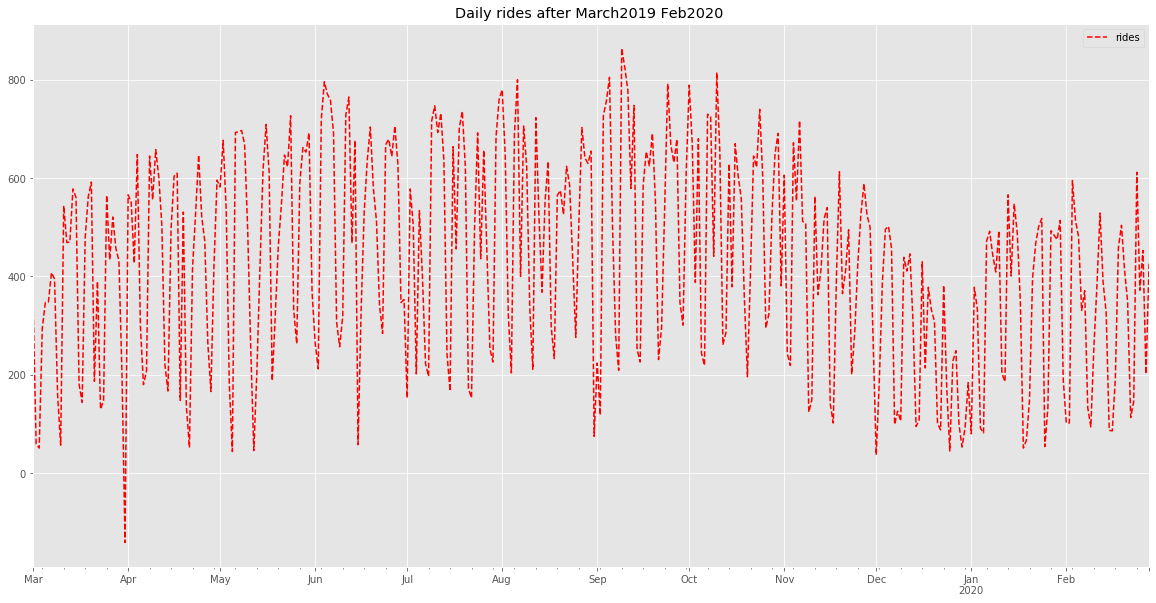

In [86]:
complete_df.plot(style=['r--'], figsize=(20, 10))
plt.title('Daily rides after March2019 Feb2020 ')

In [ ]:
# test_df = test_df.assign(missing= np.nan)
# test_df.missing[test_df.dates.isna()] = test_df.count
# test_df.info()

# impute using the rolling average, Median

In [178]:
# Rolling median 
test_df = test_df.assign(FillMedian=test_df.dates.fillna(test_df.dates.median()))
# median value of each month for the station 

test_df.plot(style=[ 'bo-', 'r*'], figsize=(20, 8))

In [ ]:
# # imputing using the rolling average
# df = df.assign(RollingMean=df.target.fillna(df.target.rolling(24,min_periods=1,).mean()))
# imputing using the rolling median

test_df= test_df.assign(RollingMedian=test_df.dates.fillna(test_df.dates.rolling(24,min_periods=1,).median()))

# imputing using the median

test_df.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 8))

# Rolling median value of each month for the station 




# Imputing using interpolation with different methods

In [ ]:
test_df = test_df.assign(InterpolateLinear=test_df.dates.interpolate(method='linear'))
test_df = test_df.assign(InterpolateTime=test_df.dates.interpolate(method='time'))


# Scoring the results and see which is better

In [ ]:
# r2_score(test_df['count'].values, test_df.RollingMedian.values)



# from sklearn.metrics import r2_score

# results = [(method, r2_score(test_df['count'].values, test_df[method].values)) for method in list(test_df)[2:6]]


# results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
# results_df.sort_values(by='R_squared', ascending=False)


# final_df= test_df[['count','InterpolateLinear', 'RollingMedian', 'dates', 'FillMedian', 'InterpolateTime' ]]
# final_df.plot(style=['b--.', 'bo', 'go', 'yx-', 'k^'], figsize=(20,10));
# plt.ylabel('Bike Rides');
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           fancybox=True, shadow=True, ncol=5, prop={'size': 14} );



# test_df['InterpolateLinear'].plot(style=['k--'], figsize=(20, 8))


# test_df.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 8))

# Using Linear Regression prediction 

# Time series : 
## total rides each day 

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calender year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $E_t$ is $y_t - T_t - S_t$.

In [91]:
# time series index 

# ts = df.dates.value_counts().to_frame('counts')
# ts.set_index(df.dates.unique(), inplace = True)

In [92]:
ts = complete_df

In [93]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Rides numbers {}".format(name))

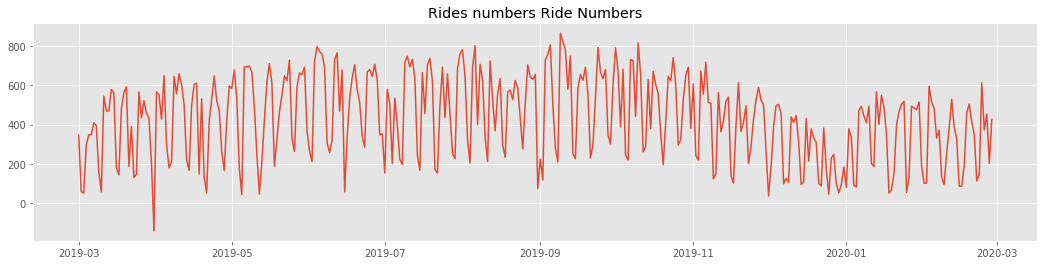

In [94]:
fig, ax = plt.subplots(1, figsize=(18, 4))

plot_trend_data(ax, 'Ride Numbers', ts)

In [95]:
s=sm.tsa.seasonal_decompose(ts, period = 1)

In [96]:
# sm.__version__

In [97]:
# python_decomposition = sm.tsa.seasonal_decompose(ts)

In [98]:
def plot_seasonal_decomposition(axs, series, sd):
    
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

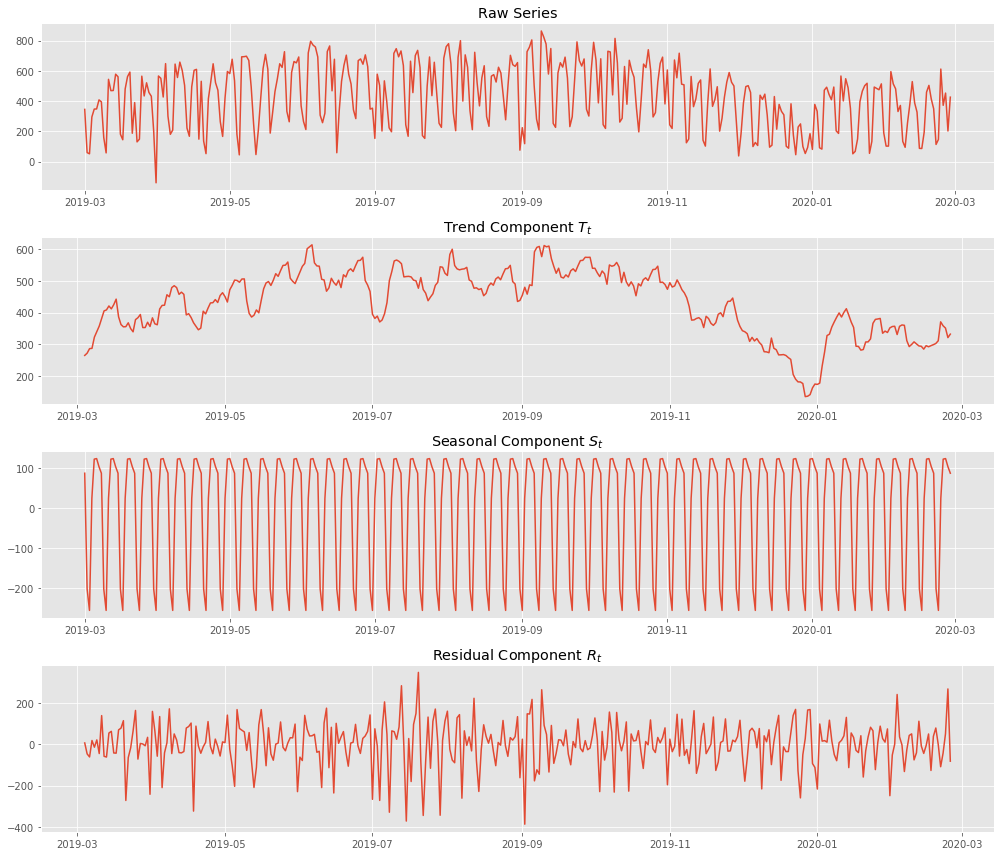

In [108]:
s=sm.tsa.seasonal_decompose(ts, period = 7)

fig, axs = plt.subplots(4, figsize=(14, 12))
plot_seasonal_decomposition(axs, ts , s)
plt.savefig("Seasonal Decompose")
plt.tight_layout()

### White Noise

The simplest possible random process from this perspective occurs when each $Y_i$ is independent from all the rest, and all the $Y$'s are identically distributed.

In this case the series is called **white noise**.

In [100]:
def white_noise(size=250):
    return pd.Series(np.random.normal(size=size))

Text(0.5, 1.0, 'White Noise Series')

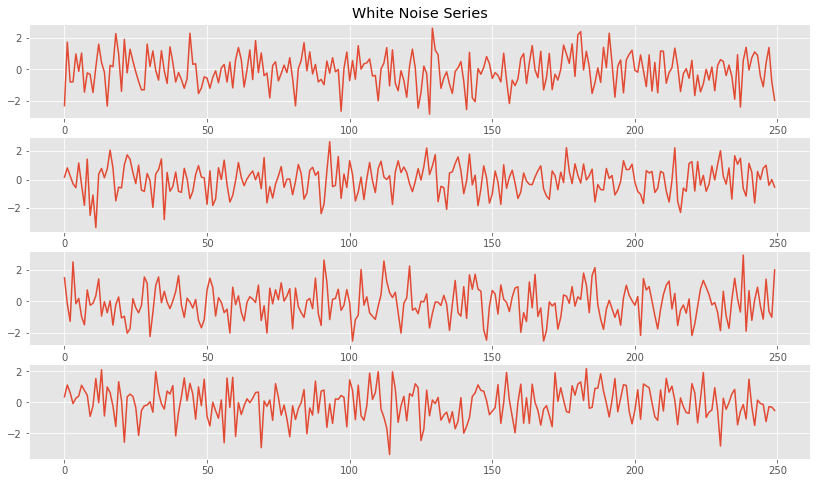

In [101]:
fig, axs = plt.subplots(4, figsize=(14, 8))
for i in range(4):
    noise = white_noise()
    axs[i].plot(noise.index, noise)
    if i == 0:
        axs[i].set_title("White Noise Series")

White noise shows no trend, no seasonal patterns, and no cyclic behaviour.

### Stationarity

In [102]:
ts.describe()


rides
count  365.000000
mean   429.558904
std    212.128291
min   -141.000000
25%    244.000000
50%    453.000000
75%    610.000000
max    864.000000

<Figure size 864x576 with 0 Axes>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a293c4690>]],
      dtype=object)

<Figure size 864x576 with 0 Axes>

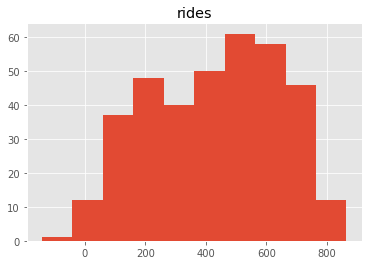

In [103]:
plt.figure(figsize = (12,8))
ts.hist()
plt.show()

In [104]:
# fig, ax = plt.subplots(1, figsize=(14, 4))
# ax.plot(ts.index, ts)
# ax.set_title("Bike rides Over Time")
# fig.tight_layout()

### After Box-Cox transformation, what does Trend-Seasonality-Residual decomposition look like?

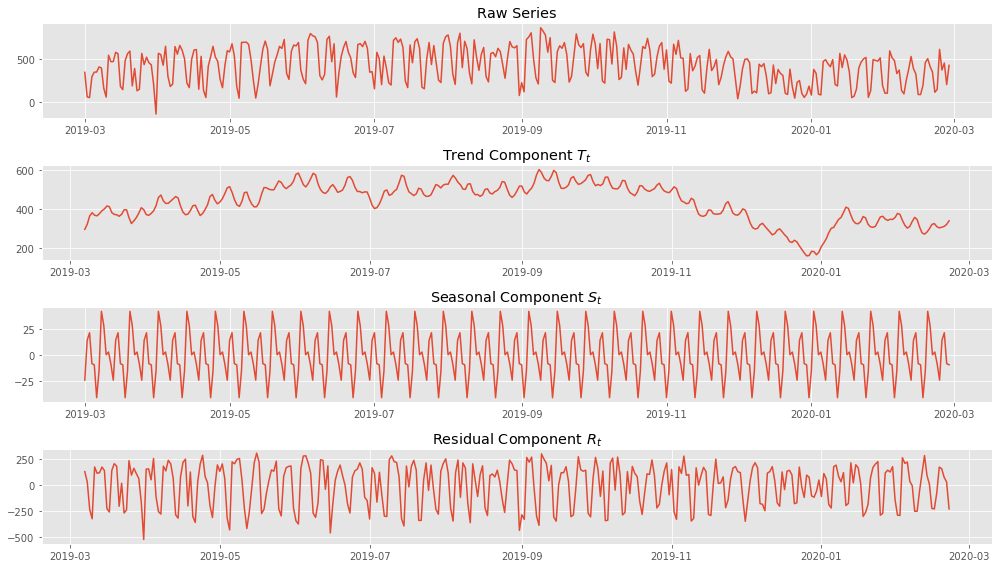

In [109]:
earnings_decomposition = sm.tsa.seasonal_decompose(ts, period=12) #experimented with period
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, ts, earnings_decomposition)
plt.tight_layout()

* A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. <br>
* A stable seasonal pattern is not stationary in the sense that the mean of the series will vary across seasons and, hence, depends on time; but it is stationary in the sense that we can expect the same mean for the same month in different years.

### Differencing

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

In [110]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

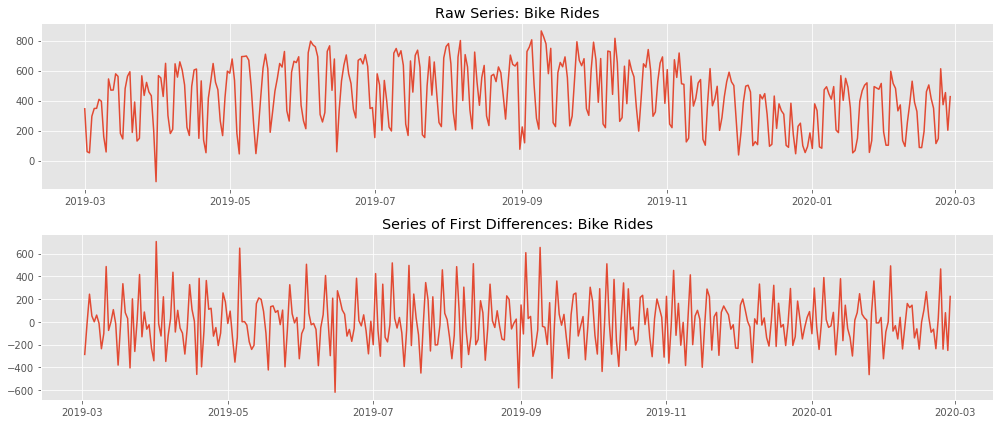

In [111]:
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_series_and_difference(axs, ts, 'Bike Rides')
fig.tight_layout()

# Random Walk
* yt=yt−m+εt. 
* Forecasts from this model are equal to the last observation from the relevant season. That is, this model gives seasonal naïve forecasts

In [112]:
def random_walk(size=250):
    noise = np.random.normal(size=(size + 1))
    walk = np.cumsum(noise)
    return pd.Series(walk)

In [113]:
def plot_random_walk(ax, size=250):
    walk = random_walk(size=size)
    ax.plot(walk.index, walk)

Text(0.5, 1.0, ' Random Walk Series')

Text(0.5, 1.0, 'Differenced Random Walk Series')

Text(0.5, 1.0, ' Random Walk Series')

Text(0.5, 1.0, 'Differenced Random Walk Series')

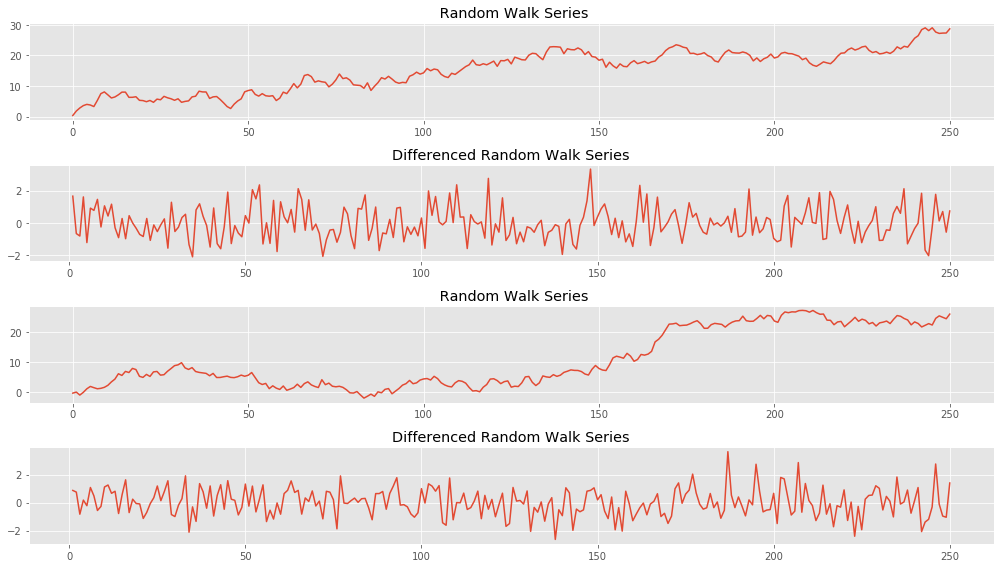

In [114]:
fig, axs = plt.subplots(4, figsize=(14, 8))
for i in range(4):
    walk = random_walk()
    diff = walk.diff()
    if i%2 == 0:
        axs[i].plot(walk.index, walk)
        axs[i].set_title(" Random Walk Series")
    if i%2 == 1:
        axs[i].plot(diff.index, diff)
        axs[i].set_title("Differenced Random Walk Series") 
plt.tight_layout()
plt.show()

In [115]:
def linear_combination_of_white_noise(size, coef):
    coef = np.asarray(coef)
    n_coef = len(coef)
    noise_size = size + len(coef)
    noise = np.random.normal(size=noise_size)
    # np.convolve reverses the second array :/
    # We need to subset the result to remove edge effects.
    lc = np.convolve(noise, coef[::-1])[(n_coef-1):(size+n_coef-1)]
    return pd.Series(lc)

In [116]:
def plot_linear_combination_of_white_noise(ax, size, coef):
    series = linear_combination_of_white_noise(size, coef)
    ax.plot(series.index, series)
    ax.set_title("Linear Combination of White Noise with Coefficients {}".format(
            str(list(coef[1:]))))

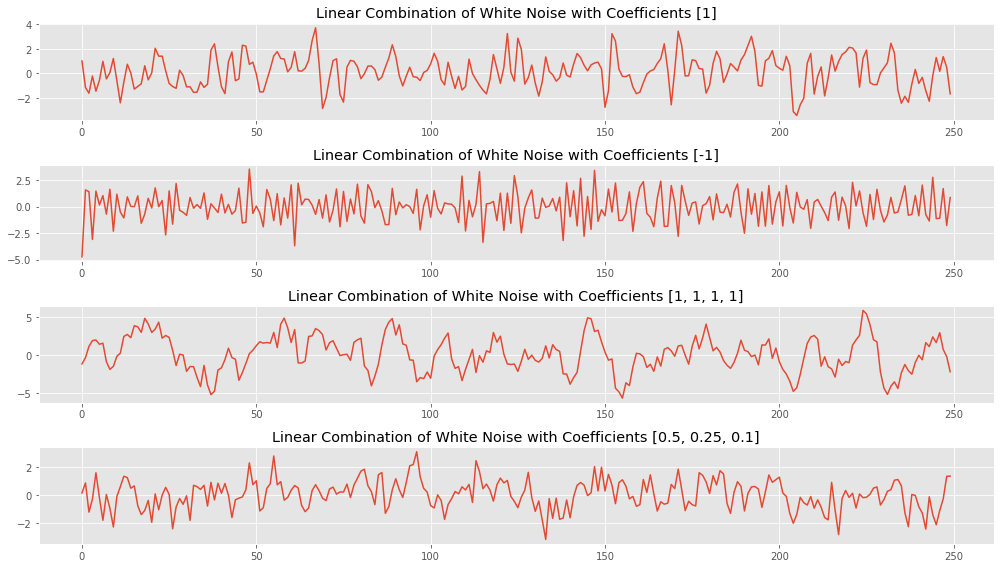

In [117]:
np.random.seed(1)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_linear_combination_of_white_noise(axs[0], 250, [1, 1])
plot_linear_combination_of_white_noise(axs[1], 250, [1, -1])
plot_linear_combination_of_white_noise(axs[2], 250, [1, 1, 1, 1, 1])
plot_linear_combination_of_white_noise(axs[3], 250, [1, 0.5, 0.25, 0.1])
plt.tight_layout()

### Tests for Stationarity

Stationarity can be hard to visualize, so there are some statistical hypothesis tests that you can use to indicate stationarity.

The **Augmented Dickey-Fuller test** is setup as follows:

  - $H_0$: The series is **not-stationary**.
  - $H_{\text{a}}$: The series is stationary.
  
It is available in stats models as `tsa.stattools.adfuller`.

In [118]:
# for i in range(5):
#     test = sm.tsa.stattools.adfuller(white_noise(size=250))
#     print("ADF p-value: {0:2.2f}".format(test[1]))

MA series are stationary:

In [119]:
for coef in [[1, 1], [1, -1], [1, 1, 1, 1], [1, 0.5, 0.25, 0.1]]:
    series = linear_combination_of_white_noise(size=250, coef=coef)
    test = sm.tsa.stattools.adfuller(series)
    print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00


In [120]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
#Plot rolling statistics:
    plt.figure(figsize=(20,10)) 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Adfuller Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [121]:
# moving_avg = ts_log.rolling(12).mean()

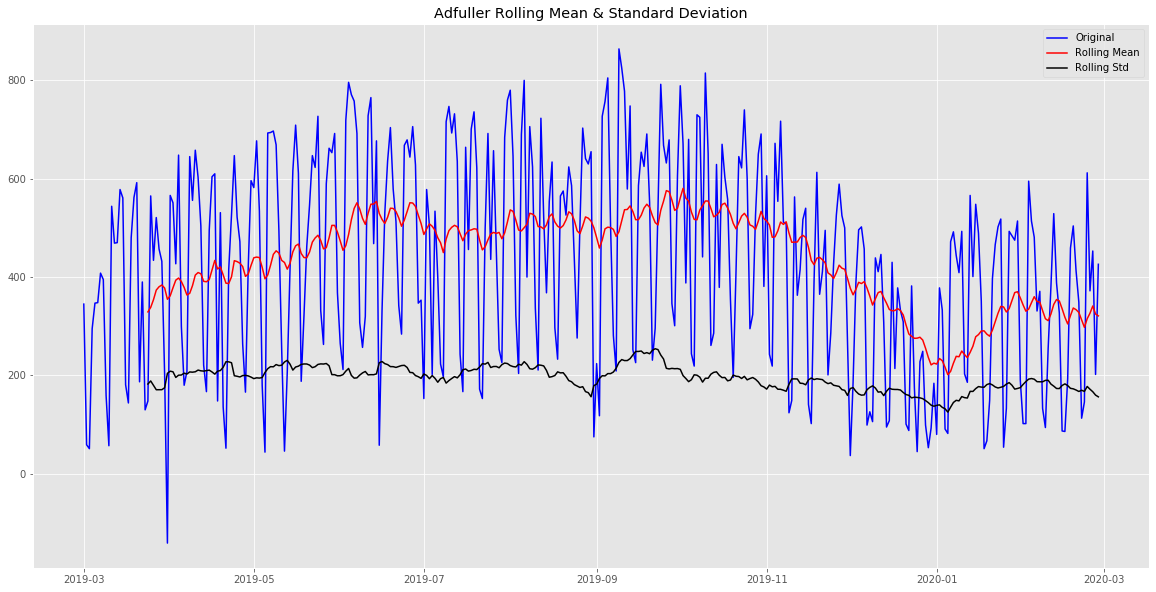

Results of Dickey-Fuller Test:
Test Statistic                  -1.933093
p-value                          0.316657
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


In [122]:

test_stationarity(ts)

# Is it stationary?
 Mean is dereasing and std is large <br>
    Test Stat < critical value.
    95% confident that  
    
# Trend  : Do difference again?


# Seasonality 

log or square root, cube root ? 

ADF p-value for the earnings series: 0.32


Text(0.5, 1.0, 'Rides Over Time')

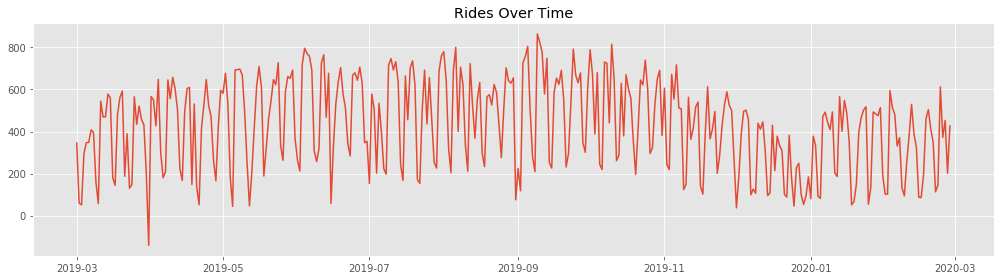

In [123]:
# test the raw data
test = sm.tsa.stattools.adfuller(ts)
print("ADF p-value for the earnings series: {0:2.2f}".format(test[1]))

# plot it
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(ts.index, ts.values)
ax.set_title("Rides Over Time")
fig.tight_layout()

# Log transfer  & square root

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Log transfer')

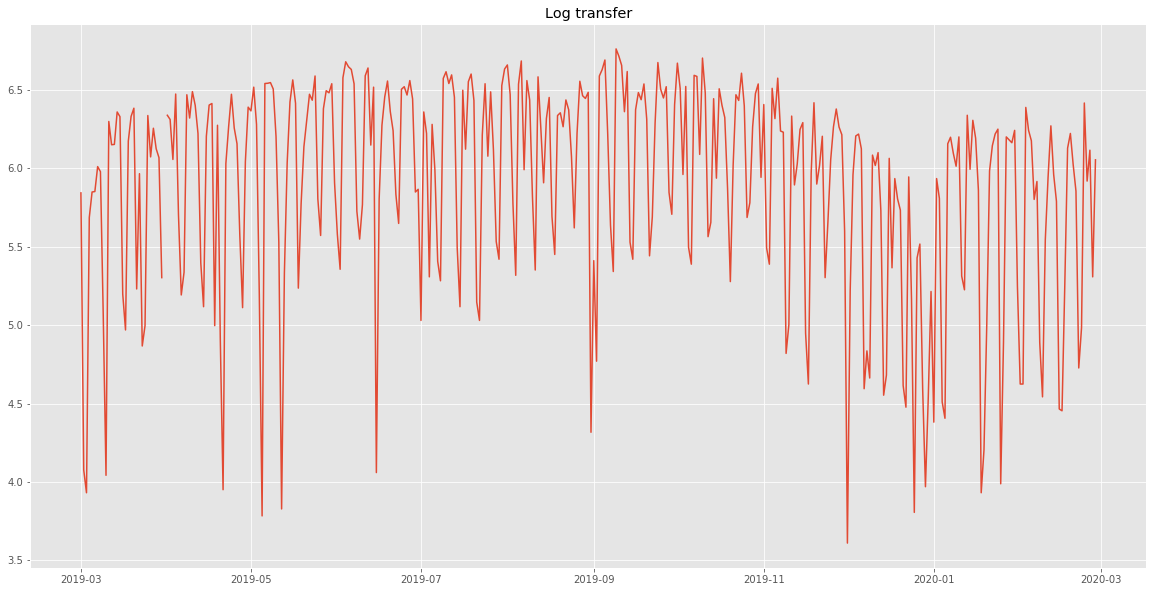

In [127]:
time_s_log = np.log(ts)
plt.figure(figsize=(20,10)) 
plt.plot(time_s_log)
plt.title('Log transfer')
plt.show()

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Square Transfer')

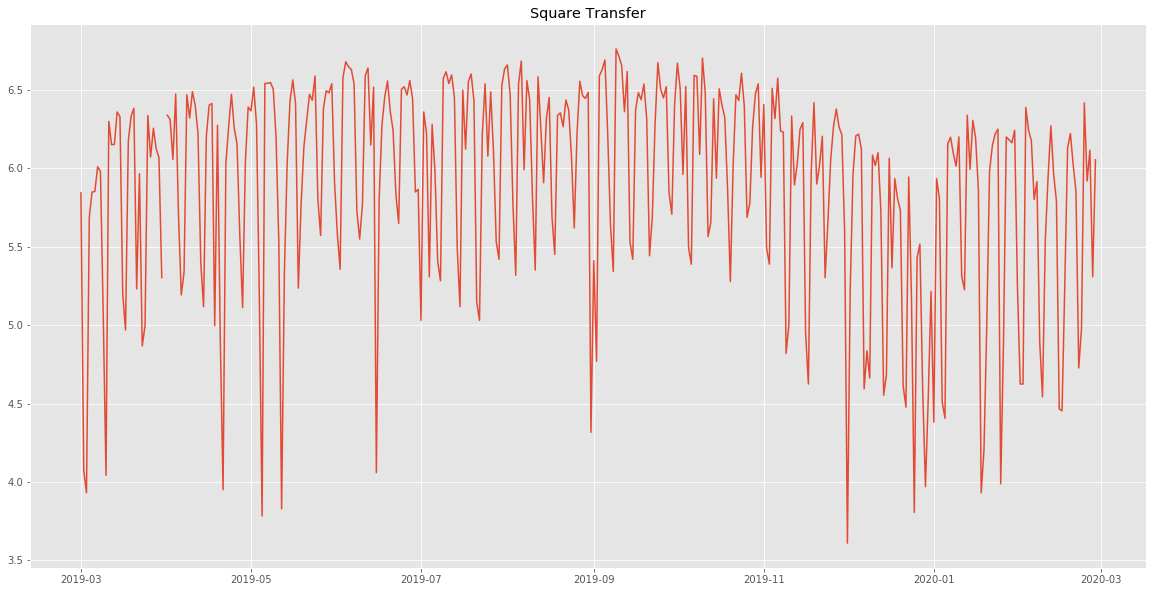

In [128]:
time_s_aqroot = np.sqrt(ts)
plt.figure(figsize=(20,10))
plt.title('Square Transfer')
plt.plot(time_s_log)

# Time Series - Models for Stationary Series

For the rest of this lecture, we will be working with *stationary* series, and developing a statistical model for them.

## Autocorrelation

In [129]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

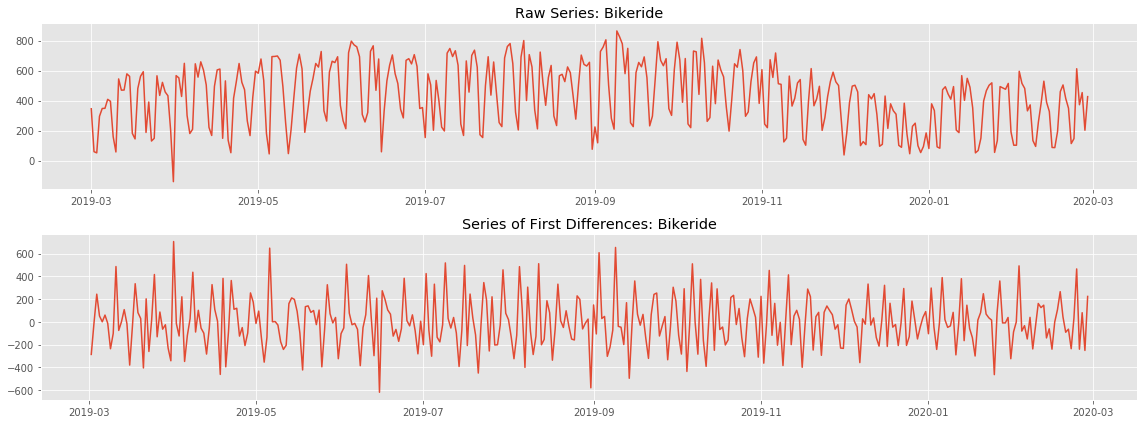

In [130]:
fig, axs = plt.subplots(2, figsize=(16, 6))
plot_series_and_difference(axs, ts, 'Bikeride')
fig.tight_layout()

We can draw some scatterplots to summarize the autocorrelation information 

Text(0.5, 1.0, 'Lag 0 AC: nan')

Text(0.5, 1.0, 'Lag 1 AC: nan')

Text(0.5, 1.0, 'Lag 2 AC: nan')

Text(0.5, 1.0, 'Lag 4 AC: nan')

Text(0.5, 1.0, 'Lag 5 AC: nan')

Text(0.5, 1.0, 'Lag 6 AC: nan')

Text(0.5, 1.0, 'Lag 7 AC: nan')

Text(0.5, 1.0, 'Lag 8 AC: nan')

Text(0.5, 1.0, 'Lag 52 AC: nan')

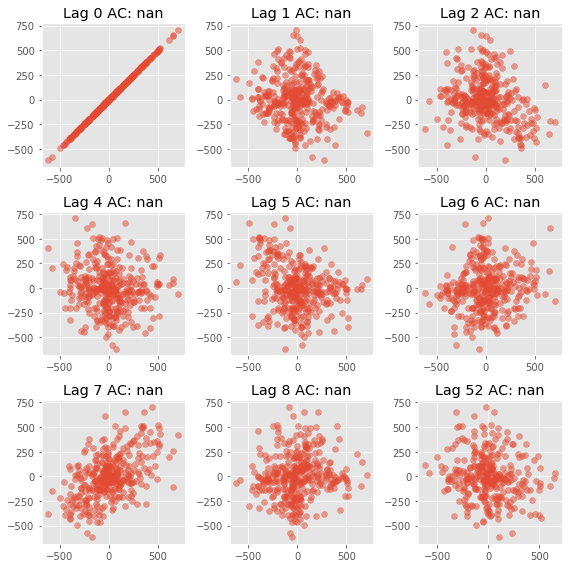

In [131]:
ride_diff = ts.diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [0,1,2,4,5,6,7,8,52]

for i, ax in zip(lags,axs.flatten()):
    rides, lagged = series_and_lagged(ride_diff, lag=i)
    autocorr = compute_autocorrelation(ride_diff, lag=i)
    ax.scatter(rides, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()
plt.show()

A more immediate way to view the autocorrelation in a series is with an **autocorrelation plot**.  

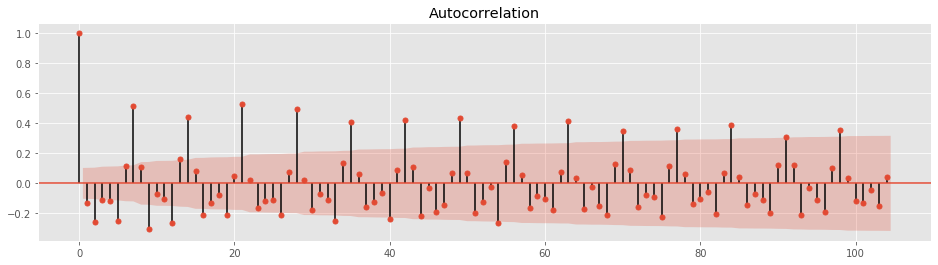

In [132]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(ride_diff, lags=2*52, ax=ax)

## Partial Autocorrelation

A **partial autocorrelation** plot controls for this effect. The partial autocorrelation at lag $k$ is the amount of correlation between $y_t$ and $y_{t-k}$ not accounted for by lags $1$ to $k-1$.

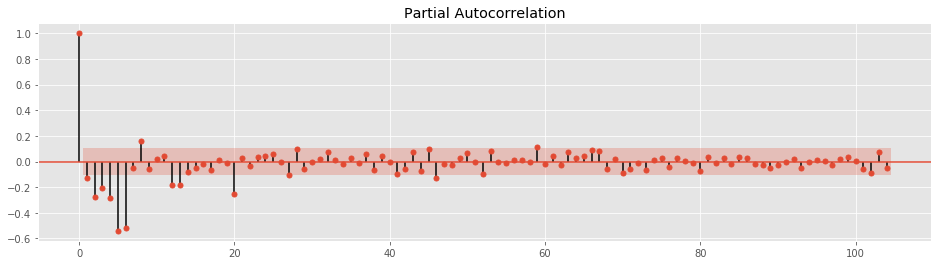

In [133]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(ride_diff, lags=2*52, ax=ax, method='ywmle')

### Autocorrelation of MA series

MA series are linear combinations of white noise with a possible constant term

$$ s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k} $$

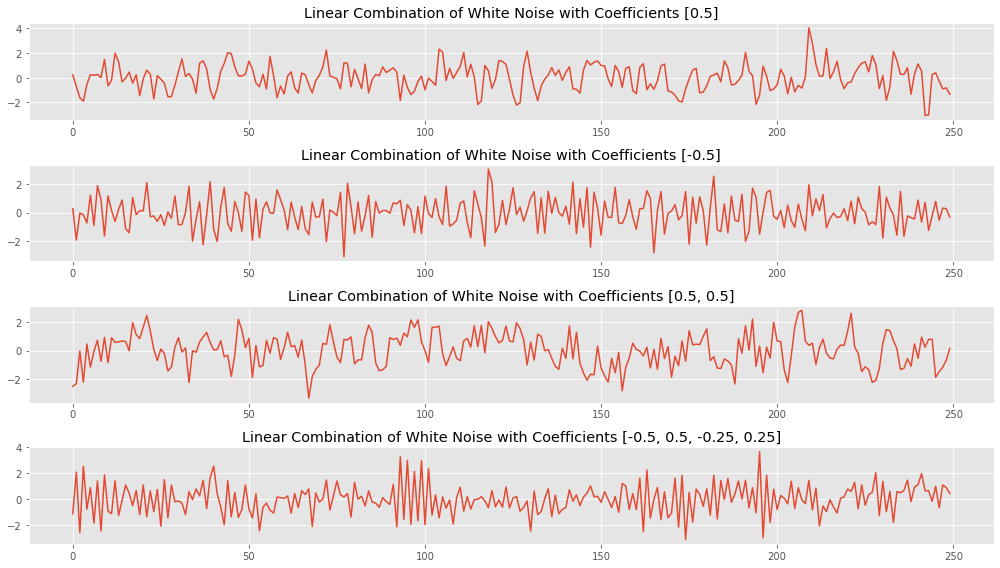

In [134]:
fig, axs = plt.subplots(4, figsize=(14, 8))

ma_coefs = [[1, 0.5], [1, -0.5], [1, 0.5, 0.5], [1, -0.5, 0.5, -0.25, 0.25]]
for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    plot_linear_combination_of_white_noise(axs[i], 250, coef)

plt.tight_layout()

Text(0.5, 1.0, 'Autocorrelation in MA With Coefficients [0.5]')

Text(0.5, 1.0, 'Autocorrelation in MA With Coefficients [-0.5]')

Text(0.5, 1.0, 'Autocorrelation in MA With Coefficients [0.5, 0.5]')

Text(0.5, 1.0, 'Autocorrelation in MA With Coefficients [-0.5, 0.5, -0.25, 0.25]')

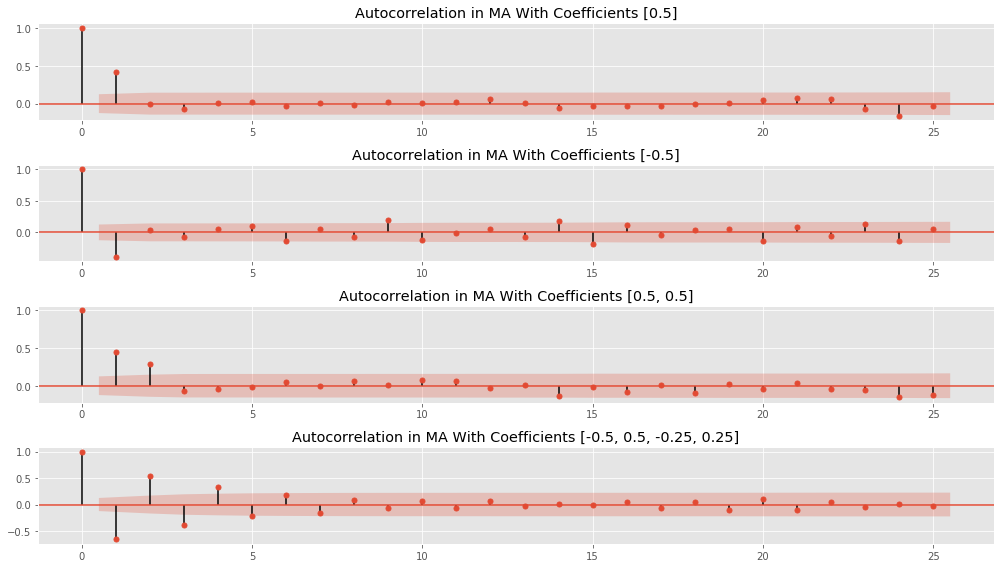

In [135]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    series = linear_combination_of_white_noise(size=250, coef=coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in MA With Coefficients {}".format(str(list(coef[1:]))))
    
plt.tight_layout()

### MA Models (moving average)

In [136]:
def fit_ma_model(series, order):

    model = ARIMA(series, order=(0, 0, order))
    return model.fit()

Let's generate some MA data, fit MA models, and compare the coefficients.

In [137]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [138]:
for coef in ma_coefs:
    ma_series = linear_combination_of_white_noise(size=250, coef=coef)
    ma_model = fit_ma_model(ma_series.values, order=(len(coef) - 1))
    print("True Coefficients: {0: <20} Estimated Coefficients: {1: <20}".format(
            str(format_list_of_floats(coef[1:])),
            str(format_list_of_floats(ma_model.params[1:]))))

True Coefficients: ['0.50']             Estimated Coefficients: ['0.51']            
True Coefficients: ['-0.50']            Estimated Coefficients: ['-0.49']           
True Coefficients: ['0.50', '0.50']     Estimated Coefficients: ['0.57', '0.55']    
True Coefficients: ['-0.50', '0.50', '-0.25', '0.25'] Estimated Coefficients: ['-0.52', '0.36', '-0.21', '0.23']


MA models recover the true coefficients from *actual* MA processes. 


Before we apply the MA model to real data, we need to know AR processes, and generalize everything to the ARIMA model.

### AR Processes

Another data generating process that (often, there are some restrictions on the coefficients) results in a stationary process is an **autoregressive** process.

In an autoregressive process, subsequent values of the series are linear combinations of previous values of the series plus some noise term (much like in regression we get a linear combination of predictors plus a noise term)

$$ y_i = \mu + b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i $$

The number of coefficients in this equation is called the *order* of the model, and we often speak of $AR(1)$ processes, $AR(2)$ processes, etc...

In [139]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coef))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

In [140]:
def plot_autoregressive_process(ax, size, coefs, init=None):
    ar = auto_regressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

Text(0.5, 1.0, 'Autoregressive Process with Coefficients [0.5]')

Text(0.5, 1.0, 'Autoregressive Process with Coefficients [-0.5]')

Text(0.5, 1.0, 'Autoregressive Process with Coefficients [1.5, -0.5]')

Text(0.5, 1.0, 'Autoregressive Process with Coefficients [1.5, -1, 0.25]')

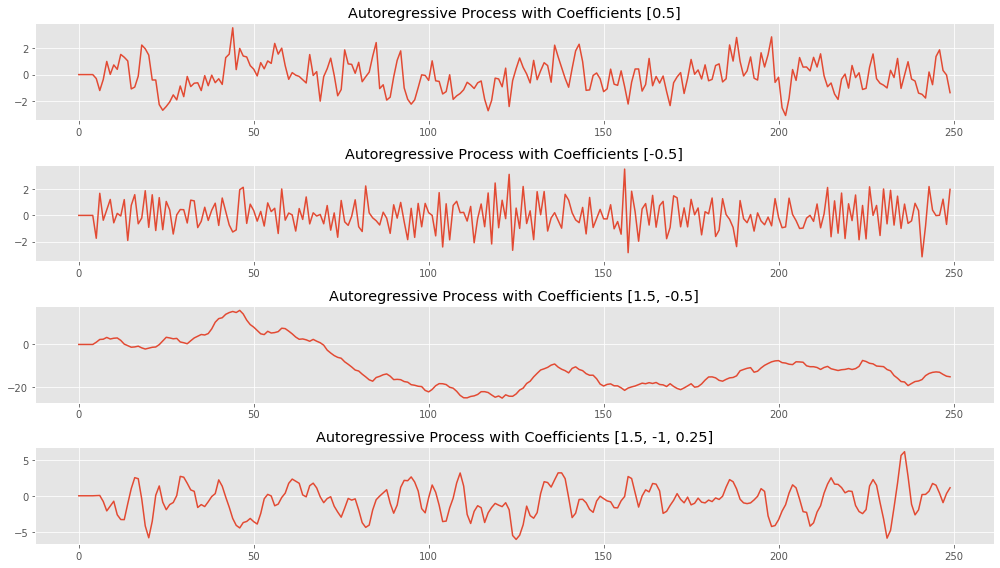

In [141]:
ar_coefs = [[0.5], [-0.5], [1.5, -0.5], [1.5, -1, 0.25]]

fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coefs) in enumerate(zip(axs, ar_coefs)):
    plot_autoregressive_process(ax, 250, coefs)
    ax.set_title("Autoregressive Process with Coefficients {}".format(str(list(coefs))))

plt.tight_layout()

Text(0.5, 1.0, 'Autocorrelation in AR With Coefficients [0.5]')

Text(0.5, 1.0, 'Autocorrelation in AR With Coefficients [-0.5]')

Text(0.5, 1.0, 'Autocorrelation in AR With Coefficients [1.5, -0.5]')

Text(0.5, 1.0, 'Autocorrelation in AR With Coefficients [1.5, -1, 0.25]')

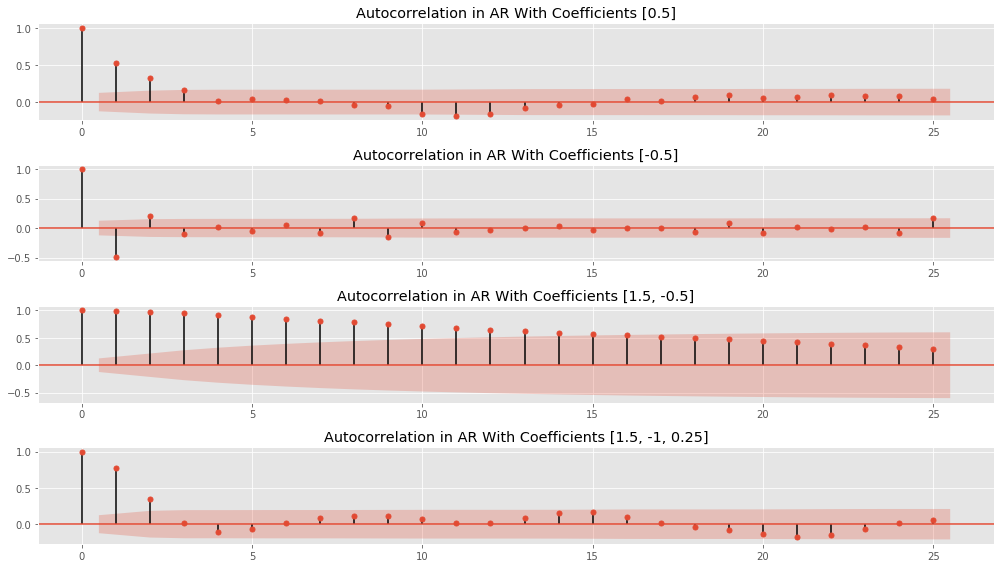

In [142]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

Text(0.5, 1.0, 'Partial Autocorrelation in AR With Coefficients [0.5]')

Text(0.5, 1.0, 'Partial Autocorrelation in AR With Coefficients [-0.5]')

Text(0.5, 1.0, 'Partial Autocorrelation in AR With Coefficients [1.5, -0.5]')

Text(0.5, 1.0, 'Partial Autocorrelation in AR With Coefficients [1.5, -1, 0.25]')

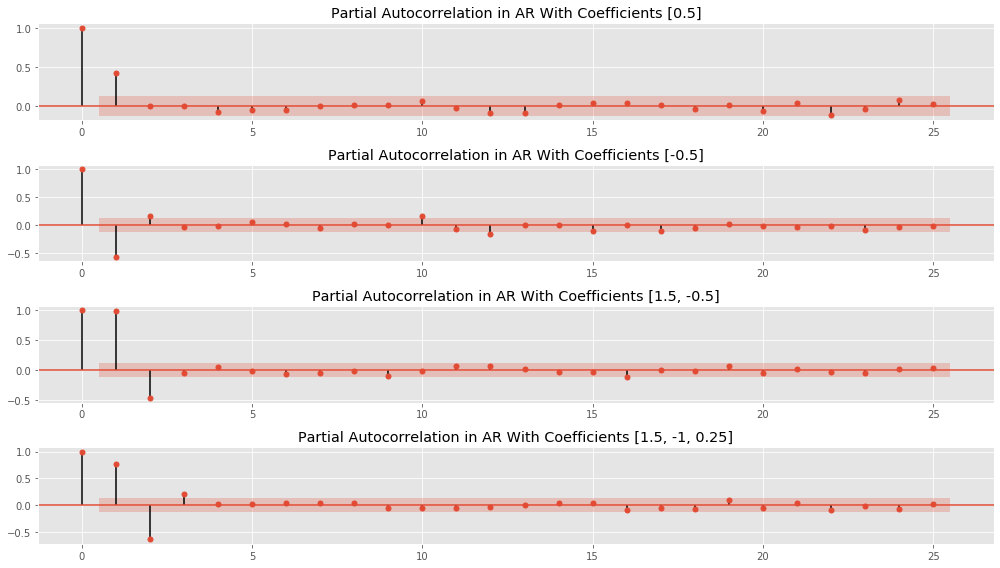

In [143]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax, method='ywmle')
    ax.set_title("Partial Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

### AR Models

Given stationary time series data, a reasonable question to ask is the following:
    
> Which AR series would be most likely to generate this data?

This is the concept behind AR models.

In [144]:
def fit_ar_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(order, 0, 0))
    return model.fit()

Let's generate some AR data, fit some AR models, then compare the coefficients.

In [145]:
for coef in ar_coefs:
    ar_series = auto_regressive_process(size=250, coefs=coef)
    ar_model = fit_ar_model(ar_series.values, order=(len(coef)))
    print("True Coefficients: {0: <26} Estimated Coefficients: {1: <26}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ar_model.params[1:]))))

True Coefficients: ['0.50']                   Estimated Coefficients: ['0.45']                  
True Coefficients: ['-0.50']                  Estimated Coefficients: ['-0.54']                 
True Coefficients: ['1.50', '-0.50']          Estimated Coefficients: ['1.60', '-0.60']         
True Coefficients: ['1.50', '-1.00', '0.25']  Estimated Coefficients: ['1.46', '-1.00', '0.27'] 


In [ ]:

# ts.index = pd.to_datetime(ts.index)
# ts.reset_index('date', inplace=True)

In [ ]:
# import numpy as np, pandas as pd
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt
# # plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

 
# # Original Series
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(ts.rides); axes[0, 0].set_title('Original Series')
# plot_acf(ts.rides, ax=axes[0, 1])

# # 1st Differencing
# axes[1, 0].plot(ts.rides.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(ts.rides.diff(), ax=axes[1, 1])

# # 2nd Differencing
# axes[2, 0].plot(ts.rides.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(ts.rides.diff().diff(), ax=axes[2, 1])

# plt.show()

# order of differencing (d) in ARIMA model

In [177]:
ts.index.name = 'date'

ts.index


ts.index = pd.to_datetime(ts.index)
ts.set_index('date', inplace=True)

In [149]:
# only for this 

ts.index = pd.to_datetime(ts.index)
ts.reset_index('date', inplace=True)

In [150]:
ts.rides.sum()

156789

In [151]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = ts.rides[:335]
test = ts.rides[335:]

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Forecast vs Actuals')

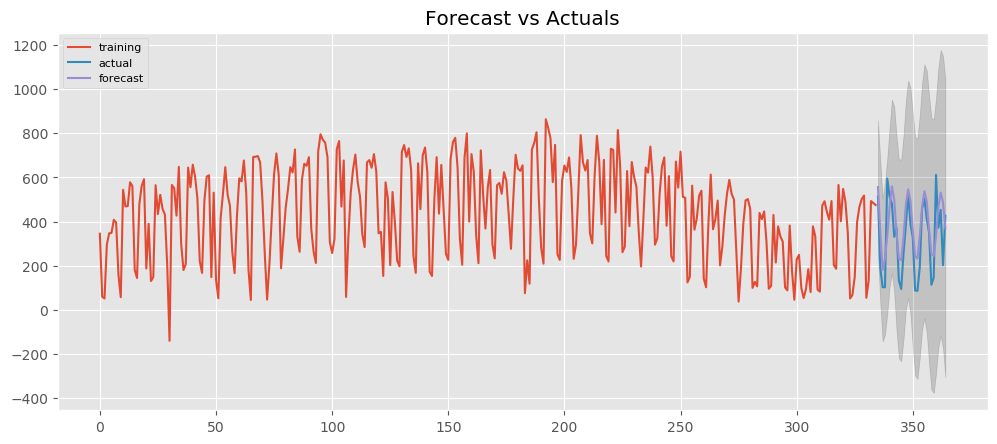

In [160]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(4, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('ARIMA testing')
plt.show()

In [153]:
# # Build Model
# model = ARIMA(train, order=(3, 2, 1))  
# fitted = model.fit(disp=-1)  
# print(fitted.summary())

# # Forecast
# fc, se, conf = fitted.forecast(73, alpha=0.05)  # 95% conf

# # Make as pandas series
# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

# ARIMA modal summary 

In [154]:
# 
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(ts.rides, order=(4,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.rides   No. Observations:                  364
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2352.089
Method:                       css-mle   S.D. of innovations            154.079
Date:                Tue, 19 May 2020   AIC                           4720.177
Time:                        04:18:06   BIC                           4751.355
Sample:                             1   HQIC                          4732.569
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1988      2.888      0.069      0.945      -5.462       5.860
ar.L1.D.rides     0.5851      0.051     11.476      0.000       0.485       0.685
ar.L2.D.rides    -0.6810      0.058    -

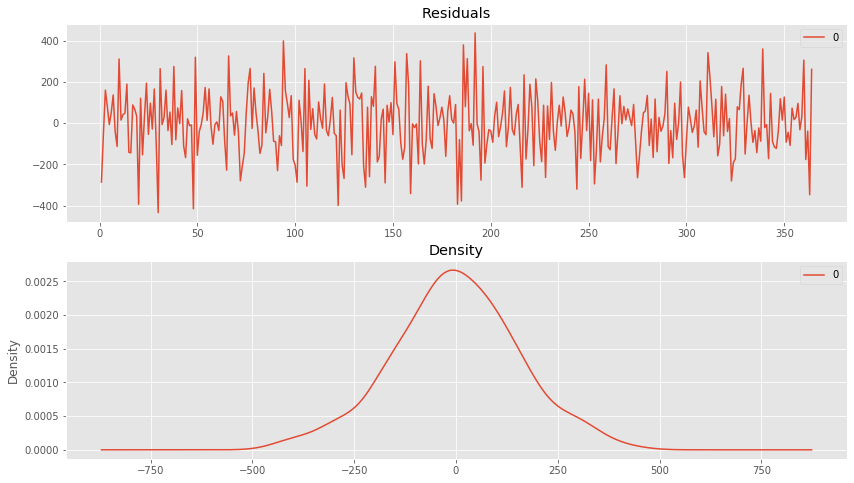

In [159]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(2,1, figsize = (14,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.savefig('Residual')
plt.show()

# Prediction

In [163]:
# ts.reindex(pd.date_range(start='3/1/2019', end='2/28/2020'))

# fig, ax = plt.subplots(1, figsize=(14, 4))
# ax.plot(ts.index, ts)
# fig = arima_model.plot_predict('2020-2-28', '2020-06', 
#                                   dynamic=True, ax=ax, plot_insample=False)

# _ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
# _ = ax.legend(loc="lower left")

# _ = ax.set_title("Bike ride Forcasts from ARIMA Model")
# plt.show()

# The END
# The end
# the end 

### ARIMA Models

The **I** in ARIMA stands for **integrated**.

The word *integration* is used here as the opposite of *difference*.

**Recall:** We often have to take the *first differences* of series we find in nature to make then *stationary*.


In [166]:
import six.moves
from statsmodels.tsa.arima_process import ArmaProcess

def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in six.moves.range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

In [167]:
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

Text(0.5, 1.0, 'ARIMA Process with AR=[0.5], MA=[0.5], d=0')

Text(0.5, 1.0, 'ARIMA Process with AR=[0.5], MA=[0.5], d=1')

Text(0.5, 1.0, 'ARIMA Process with AR=[0.5], MA=[-0.5], d=0')

Text(0.5, 1.0, 'ARIMA Process with AR=[0.5], MA=[-0.5], d=1')

Text(0.5, 1.0, 'ARIMA Process with AR=[-0.5], MA=[0.5], d=0')

Text(0.5, 1.0, 'ARIMA Process with AR=[-0.5], MA=[0.5], d=1')

Text(0.5, 1.0, 'ARIMA Process with AR=[-0.5], MA=[-0.5], d=0')

Text(0.5, 1.0, 'ARIMA Process with AR=[-0.5], MA=[-0.5], d=1')

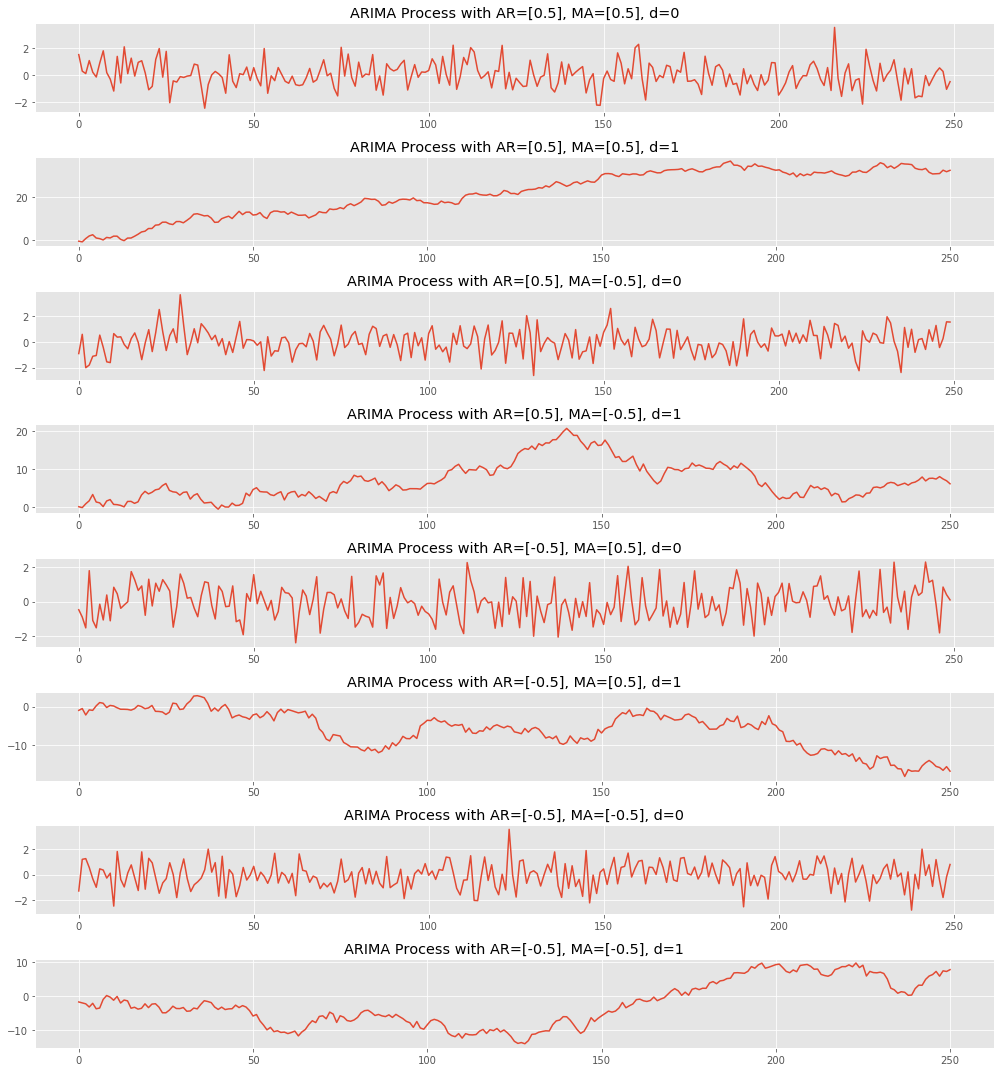

In [168]:
import itertools

ar_coefs = [[0.5], [-0.5]]
ma_coefs = [[0.5], [-0.5]]
ds = [0, 1]

fig, axs = plt.subplots(8, figsize=(14, 15))

for ax, (ar, ma, d) in six.moves.zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
    plot_arima_process(ax, 250, ar, ma, d)
    ax.set_title("ARIMA Process with AR={}, MA={}, d={}".format(
        str(list(ar)), str(list(ma)), d))
    
plt.tight_layout()

In [169]:
# fig, axs = plt.subplots(2, figsize=(14, 4))
# plot_series_and_difference(axs, ts, "Bike rides")
# plt.tight_layout()

In [176]:
ride_differences = ts.diff()[1:]
test = sm.tsa.stattools.adfuller(ts)
print("ADF p-value for differenced electric series: {0:2.2f}".format(test[1]))

In [ ]:
# second difference since p-value is not stationary 

d2 = ride_differences.diff()[1:]
test1 = sm.tsa.stattools.adfuller(ride_differences)
print("ADF p-value for differenced electric series: {0:2.2f}".format(test1[1]))

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(d2, lags=25, ax=ax)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(d2, lags=25, ax=ax, method='ywmle')

In [ ]:
arima_model = ARIMA(ts, order=(3, 1, 0)).fit()

In [ ]:
print("ARIMA(3, 1, 0) coefficients from model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    arima_model.params[0], 
        format_list_of_floats(list(arima_model.params[1:]))
    ))

In [ ]:
arima_model = ARIMA(d2, order=(3, 1, 0)).fit()

In [ ]:
print("ARIMA(3, 1, 0) coefficients from model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    arima_model.params[0], 
        format_list_of_floats(list(arima_model.params[1:]))
    ))

In [ ]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(d2.index, d2)
ax[0].set_title("First Differences")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(d2), 
                                             list(arima_model.params)[1:])
    simulated_data.index = d2.index
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from  Model Fit")
    
plt.tight_layout()

We can also use the fit model to project electric sales into the future.

In [ ]:
d2.reindex(pd.date_range(start='3/1/2019', end='2/28/2020'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(d2.index, d2)
fig = arima_model.plot_predict('2020-2-28', '2020-04', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Bike ride Forcasts from ARIMA Model")
plt.show()

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(arima_model.resid.index, arima_model.resid)
ax.set_title("Residuals from arima Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(arima_model.resid, lags=50, ax=ax)

# Prediction after applying log to de-seasonalize 

In [ ]:
d2.reindex(pd.date_range(start='3/1/2019', end='2/28/2020'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(d2.index, d2)
fig = arima_model.plot_predict('2020-2-28', '2020-06', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Bike ride Forcasts from ARIMA Model")
plt.show()

In [ ]:
d2.reindex(pd.date_range(start='3/1/2019', end='2/28/2020'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(d2.index, d2)
fig = arima_model.plot_predict('2020-2-28', '2020-06', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Bike ride Forcasts from ARIMA Model")
plt.show()

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(arima_model.resid.index, arima_model.resid)
ax.set_title("Residuals from arima Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(arima_model.resid, lags=50, ax=ax)

### Model Selection: AIC

We made our selection of model based on the autocorrelation and partial autocorrelation plot, which is a good first step.

The overall procedure we followed is called the **Box-Jenkins Method**.

Hyndmann recommends also trying a few models that are "close by", varying the ARMA parameters slightly, and then selecting the best model from the results using an information criteria.

In [ ]:
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(ts, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

The $ARIMA(3, 1, 1)$ model has a *slightly* better AIC, so following Hyndmann, we would select this as our final model.

In [ ]:
# log transfered to deseasonalize 
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(time_s_log, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

# Moving Average 

<Figure size 1440x720 with 0 Axes>

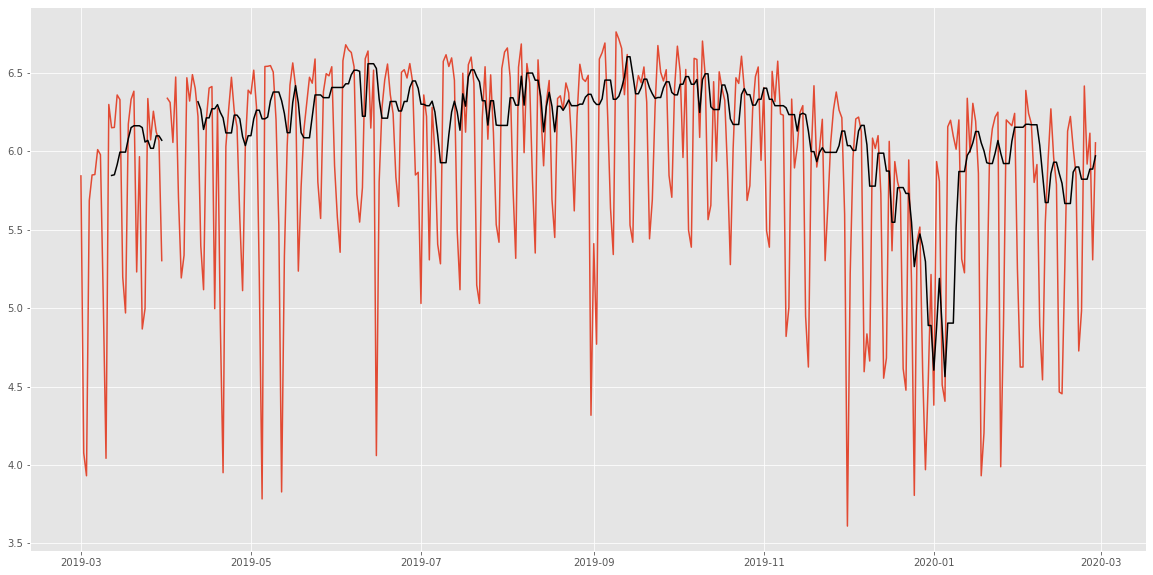

In [171]:
move_avg = time_s_log.rolling(12).median()
plt.figure(figsize=(20,10)) 

plt.plot(time_s_log)
plt.plot(move_avg, color='black')
plt.show()

In [172]:
# substract rolling mean from teh original series 
avg_diff = move_avg - time_s_log
avg_diff.head()

rides
date             
2019-03-01    NaN
2019-03-02    NaN
2019-03-03    NaN
2019-03-04    NaN
2019-03-05    NaN

In [173]:
avg_diff.dropna(inplace=True)
avg_diff.head()

rides
date                
2019-03-12 -0.304168
2019-03-13 -0.301969
2019-03-14 -0.444030
2019-03-15 -0.334644
2019-03-16  0.796579

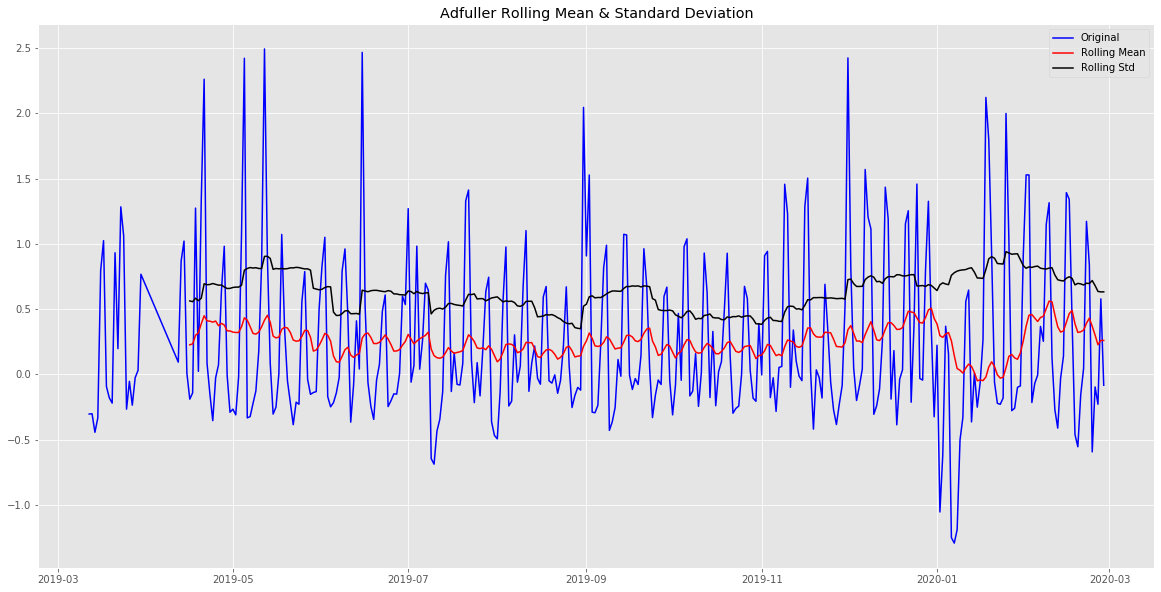

Results of Dickey-Fuller Test:
Test Statistic                  -5.467898
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    328.000000
Critical Value (1%)             -3.450445
Critical Value (5%)             -2.870392
Critical Value (10%)            -2.571486
dtype: float64


In [174]:
test_stationarity(avg_diff)

<Figure size 1440x720 with 0 Axes>

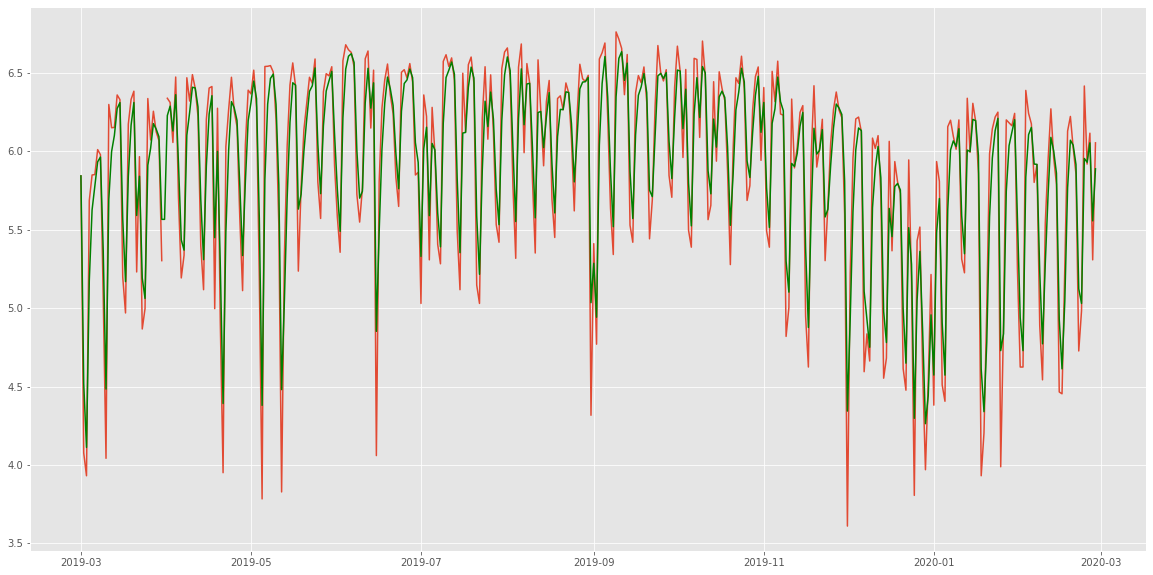

In [175]:
# ewma: exponentially waighted moving average; account for decay factor 
decay_avg = time_s_log.ewm(com=0.5).mean()
plt.figure(figsize=(20,10)) 

plt.plot(time_s_log)
plt.plot(decay_avg, color='green')

# time_s_log.ewm(com=0.5).mean()
# # df.ewm(com=0.5).mean()
